# <center> MSG말고 "ESG"에 투자하세요!<center/>

## <center>: Y&Z세대의 투자 특징 분석을 통한 앞으로의 방향성 제시 </center><br><br>

####  Team 놀면뭐하니

# 들어가며

&nbsp; 20-30대로 이루어진 Y&Z 세대는 경제 불황시기에 사회에 진출하며 경제적 불안정함으로 인해 많은 것을 포기해야 하는 'n포세대'로 불리웠습니다. 특히 불안정한 노동 현실로 인해 '일자리 부족'과 부동산 상승율을 따라가지 못하는 임금 상승률 때문에 '내 집 마련'이 인생의 목표가 되어 버린 Y&Z세대는 노동소득 이외의 곳으로 눈을 돌렸고, 2020년 초 코로나로 인한 경제 혼란과 맞물리며 이른바 '동학개미운동'이 일어났습니다.<br><br>
&nbsp; 이제 Y&Z세대는 주식 시장에서 큰 부분을 차지하고 있고, 그 영향력은 계속해서 늘어날 것으로 보입니다. 따라서 이번 분석에서는 Y&Z세대의 주식 거래 데이터를 분석하여 시각화하고, 이를 통해 Y&Z세대의 주식 투자 특징을 정의하였으며, 모델링을 통해 특징들의 영향력과 중요도를 확인하였습니다. 마지막으로, Y&Z세대의 투자 성과를 평가하여 이에 맞는 상품 아이디어를 제안하고자 합니다.

<br><br>
## 목차<br>

**1. 서론**
  1. 데이터 전처리
  2. 주식 시장 흐름 파악
      - 전체 데이터에 대한 시각화
    
**2. 본론**
  1. Y&Z세대의 특징
      - 간편함 추구
      - 단기적인 수익성 추구
      - 다양한 분야에 대한 관심
  2. 모델링
      - XGBoost 모델링
      - SHAP value 해석
    
**3. 결론**
  1. 제안
      - 수익률 평가
      - 신규 서비스 제안 
  2. 맺으며

## 사용 데이터<br>
주어진 데이터를 모두 활용하고자 했습니다.<br>
- cus_info.csv (고객 정보 데이터)
- act_info.csv (계좌 정보 데이터)
- iem_info.csv (주식 종목 데이터)
- trd_kr.csv (국내 주식 매매 데이터)
- trd_oss.csv (해외 주식 매매 데이터)

외부데이터의 경우, 대부분 크롤링을 통해 수집하였고 수집된 외부 데이터는 모두 메일로 첨부하였습니다. <br>
- 국내 주식 종목 소분류 및 상장 일자 (출처: 네이버 금융)
- 국내 주식 대분류 및 중분류 리스트 (출처: wiseindex.com)
- 국내 기업 ESG 등급 (출처: KCGS 한국기업지배구조원)
- 국내 주식 주가 (출처: 'Finance Data Reader' package)
- KOSPI 주가 (출처: 'Fianance Data Reader' package)
- 해외 주식 type (출처: investing.com)

# 1. 서론

#### 패키지 호출

In [1]:
library(tidyverse)
library(gridExtra)
library(magrittr)
library(data.table)
library(lubridate)
library(gtools)
library(plotly)
library(showtext)
library(xts)
options(dplyr.summarise.inform = FALSE)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

√ ggplot2 3.3.0     √ purrr   0.3.4
√ tibble  3.0.3     √ dplyr   1.0.2
√ tidyr   1.1.2     √ stringr 1.4.0
√ readr   1.3.1     √ forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine



Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidyr':

    extract



Attaching package: 'data.table'


The following objects are masked from 'package:dplyr':

    between, first, last


The following object is masked from 'package:purrr':

    transpose



Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, w

#### 데이터 불러오기

In [2]:
cus_info <- fread("2_cus_info.csv", encoding = 'UTF-8')
act_info <- fread("2_act_info.csv", encoding = 'UTF-8')
iem_info <- fread("2_iem_info.csv", encoding = 'UTF-8')
trd_kr <- fread("2_trd_kr.csv", encoding = 'UTF-8')
trd_oss <- fread("2_trd_oss.csv", encoding = 'UTF-8')

# 외부데이터
cat_listed <- fread("cat_listed.csv", encoding = 'UTF-8')
wics <- fread('WICS.csv', encoding='UTF-8')
ESG <- fread("ESG_data.csv", encoding = 'UTF-8')
oss_type <- fread('oss_type.csv')

## 1. 데이터 전처리

#### 전처리 1: 세대 변수 생성 및 제공 데이터 JOIN

데이터를 합치기 전, cus_age 변수를 이용해 10대 이하는 'BABY', 20-30대는 'Y&Z', 40-50대는 'X', 그 이상은 'OLD'로 generation 변수를 만들어주었습니다.

In [3]:
# Geneartion 변수 만들기
cus_info <- cus_info %>% mutate(gen=ifelse((cus_age==20|cus_age==25|cus_age==30|cus_age==35),'Y&Z',
                                         ifelse((cus_age==40|cus_age==45|cus_age==50|cus_age==55),'X',
                                            ifelse(cus_age==0,'BABY','OLD'))))

# 데이터 JOIN
## 국내 데이터
trd_kr_join <- trd_kr %>% left_join(iem_info, by = c('iem_cd'='iem_cd'))
trd_kr_join <- trd_kr_join %>% left_join(act_info, by = c('act_id'='act_id'))
trd_kr_join <- trd_kr_join %>% left_join(cus_info, by = c('cus_id'='cus_id'))

## 해외 데이터
oss_dat <- trd_oss %>% left_join(act_info, by = c('act_id'='act_id'))
oss_dat <- oss_dat %>% left_join(cus_info, by = c('cus_id'='cus_id'))
oss_dat <- oss_dat %>% left_join(iem_info, by = c('iem_cd'='iem_cd'))

#### 전처리 2: type 변수 생성 및 외부 데이터 JOIN

국내 주식 종목의 이름을 보고 type을 나눠주었습니다.

In [4]:
kr_dat <- trd_kr_join
kr_dat$type <- 'NA'
kr_dat[str_detect(kr_dat$iem_krl_nm, '보통주')]$type <- '일반주식'
kr_dat[str_detect(kr_dat$iem_krl_nm, '우선주')]$type <- '일반주식'
kr_dat[str_detect(kr_dat$iem_krl_nm, '투자신탁')]$type <- 'ETF'
kr_dat[str_detect(kr_dat$iem_krl_nm, '상장지수증권')]$type <- 'ETN'
kr_dat[str_detect(kr_dat$iem_krl_nm, '파생결합증권')]$type <- 'ETN'
kr_dat[str_detect(kr_dat$iem_eng_nm, 'ETF')]$type <- 'ETF'
kr_dat[str_detect(kr_dat$iem_eng_nm, 'ELW')]$type <- 'ELW'
kr_dat[str_detect(kr_dat$iem_eng_nm, 'ETN')]$type <- 'ETN'
# 이름이 길어서 분류되지 못한 종목을 찾아서 분류해주었습니다.
kr_dat[kr_dat$iem_krl_nm == '미래에셋TIGER모닝스타글로벌4차산업혁신기술증권상장지수투자신']$type <- 'ETF'
kr_dat[kr_dat$iem_krl_nm == '미래에셋맵스아시아퍼시픽부동산공모1호']$type <- 'ETF'
kr_dat[str_detect(kr_dat$iem_krl_nm, '미래에셋 TIGER KIS부동산인프라채권TotalReturn부동산상장지수')]$type <- 'ETF'
kr_dat[kr_dat$type == 'NA']$type <- '일반주식'
sum(is.na(kr_dat$type))

[1] 0

필요한 외부 데이터도 합쳐주었습니다.

In [5]:
# 소분류 및 상장일자 데이터 합치기
kr_dat %<>% left_join(cat_listed, by = c('iem_cd' = 'iem_cd'))

# 중분류 및 대분류 데이터 합치기
kr_dat %<>% left_join(wics, by = c("category"="V5"))

kr_dat %<>% select(-c('V2', 'V4')) 
colnames(kr_dat)[c(24,25)] = c('big_cat', 'mid_cat')

분류 카테고리가 NA인 종목 중 type이 ETF, ETN, ELW인 종목들은 '수익증권형'이라는 범주로 분류해주었습니다.

In [6]:
kr_dat[kr_dat$type != '일반주식',]$category <- '수익증권형'

In [7]:
# ESG 데이터 합치기
ESG %<>% select(-iem_krl_nm)
kr_dat %<>% left_join(ESG, by = c('iem_cd' = 'iem_cd'))

#### 전처리 3: NA 처리

In [8]:
#type이 'ETF, ETN, ELW'인 종목들은 대/중/소분류 모두 '수익증권형' 범주로 넣었습니다.
kr_dat[kr_dat$type != '일반주식',]$category <- '수익증권형'
kr_dat[kr_dat$type != '일반주식',]$mid_cat <- '수익증권형'
kr_dat[kr_dat$type != '일반주식',]$big_cat <- '수익증권형'

kr_dat[is.na(kr_dat$category),]$category <- '미분류'
kr_dat[is.na(kr_dat$big_cat),]$big_cat <- '미분류'
kr_dat[is.na(kr_dat$mid_cat),]$mid_cat <- '미분류'
kr_dat[is.na(kr_dat$ESG),]$ESG <- '미분류'
kr_dat[is.na(kr_dat$E),]$E <- '미분류'
kr_dat[is.na(kr_dat$S),]$S <- '미분류'
kr_dat[is.na(kr_dat$G),]$G <- '미분류'
kr_dat[kr_dat$ESG == '']$ESG <- '미분류'
kr_dat[kr_dat$E == '']$E <- '미분류'
kr_dat[kr_dat$S == '']$S <- '미분류'
kr_dat[kr_dat$G == '']$G <- '미분류'
# listed_date(상장일자)를 제외하고 NA가 모두 채워졌습니다.

head(kr_dat)

act_id,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd,...,gen,type,listed_date,category,big_cat,mid_cat,ESG,E,S,G
<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,20190102,1,12,13,A215600,2,35,74200,3,...,X,일반주식,2016/12/06,생물공학,건강관리,제약과생물공학,C,D,C,B
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,20190102,2,12,12,A001060,2,20,41100,3,...,X,일반주식,1976/06/14,제약,건강관리,제약과생물공학,B,B,B+,B
effb34815e1b7efb34beb550f604ede8ac71a5a71edb30a0250e48c3b1bcafdb,20190102,1,14,14,A281820,2,20,9460,4,...,X,일반주식,2017/12/05,반도체와반도체장비,IT,반도체와반도체장비,B,B,B,B
fea6c038cb7236a02d1e779262698a36219b4c9b527ab10328f82fe08ccc5d91,20190102,1,12,12,A006650,2,1,148500,3,...,Y&Z,일반주식,1999/08/11,화학,소재,소재,B,B+,B+,C
fea6c038cb7236a02d1e779262698a36219b4c9b527ab10328f82fe08ccc5d91,20190102,2,12,13,A051360,2,10,6550,3,...,Y&Z,일반주식,2004/11/19,디스플레이장비및부품,IT,디스플레이,미분류,미분류,미분류,미분류
fea6c038cb7236a02d1e779262698a36219b4c9b527ab10328f82fe08ccc5d91,20190102,3,12,13,A051360,2,10,6560,3,...,Y&Z,일반주식,2004/11/19,디스플레이장비및부품,IT,디스플레이,미분류,미분류,미분류,미분류


#### 전처리 4: 데이터 타입 변환 및 Factor형 변수들의 level 이름 변경

날짜형 변수들과 범주형 변수들의 타입을 변환해주었고, 저희가 분석에 사용할 범주형 변수들의 level 이름을 이해하기 쉽게 변경해주었습니다.

In [9]:
# 변수의 타입 변경
kr_dat %<>% mutate_if(is.character, as.factor)
kr_dat %<>% mutate_if(is.integer, as.factor) 
kr_dat$act_opn_ym = paste(as.character(kr_dat$act_opn_ym), '01', sep = '-') %>% ymd()
kr_dat$orr_dt %<>%ymd()
kr_dat$listed_date %<>% ymd()

# Factor형 변수들의 level 이름 변경
kr_dat$tco_cus_grd_cd <- factor(kr_dat$tco_cus_grd_cd, labels = c('-','탑클래스','골드','로얄','그린','블루','-'), order = T)
kr_dat$ivs_icn_cd <- factor(kr_dat$ivs_icn_cd, labels = c('-','-','안정형','안정추구형','위험중립형','적극투자형','공격투자형','전문투자자형'), order = T)
kr_dat$sby_dit_cd <- factor(kr_dat$sby_dit_cd, labels = c('매도','매수'))
kr_dat$orr_mdi_dit_cd <- factor(kr_dat$orr_mdi_dit_cd, labels = c('영업점','유선','MTS','HTS'))
kr_dat$gen <- factor(kr_dat$gen, levels = c('BABY','Y&Z','X','OLD'), order = T)
kr_dat$ESG <- factor(kr_dat$ESG, levels = c('A+','A','B+','B','C','D','미분류'), order = T)
kr_dat$E <- factor(kr_dat$E, levels = c('A+','A','B+','B','C','D','미분류'), order = T)
kr_dat$S <- factor(kr_dat$S, levels = c('A+','A','B+','B','C','D','미분류'), order = T)
kr_dat$G <- factor(kr_dat$G, levels = c('A+','A','B+','B','C','D','미분류'), order = T)

## 2. 주식 시장 흐름 파악

#### - 전체 거래량 및 세대별 거래량 시각화

최종 국내 주식 매매 데이터인 *'kr_dat'* 를 이용해 2019년 1월부터 2020년 6월까지의 거래 횟수의 추이를 살펴보았습니다.

'showtext.auto()' is now renamed to 'showtext_auto()'
The old version still works, but consider using the new function in future code



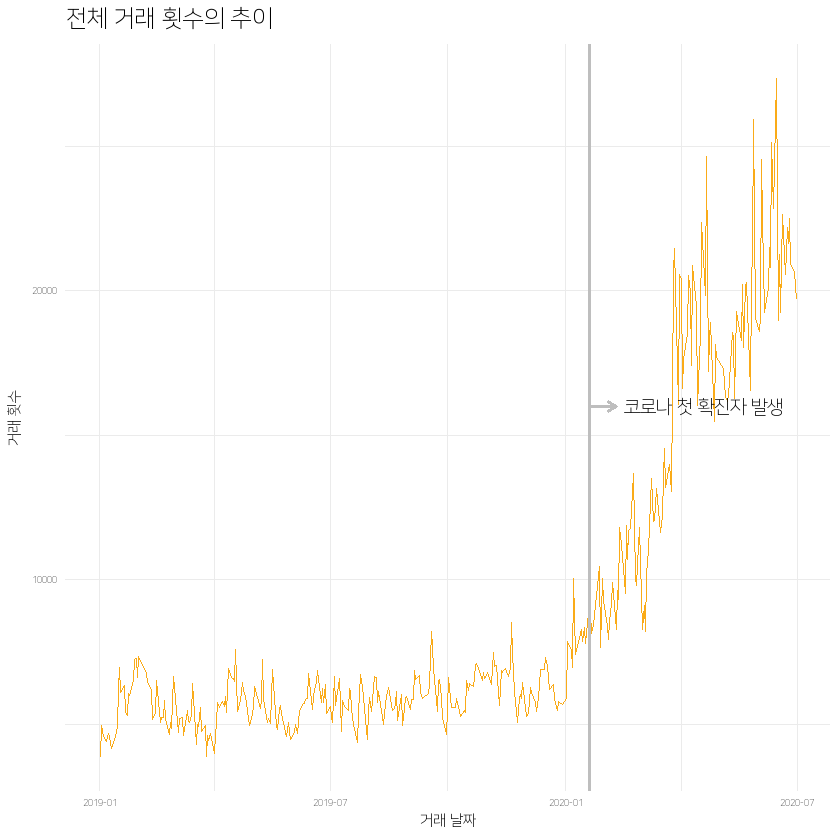

In [11]:
font_add(family = 'square',regular='NanumSquare_acL.ttf')
showtext.auto()

kr_dat %>% group_by(orr_dt) %>% tally() %>% 
  ggplot(aes(x = orr_dt, y = n)) +
  geom_line(color = "#FAAB18") +
  labs(x = "거래 날짜", y = "거래 횟수", title = "전체 거래 횟수의 추이") +
  geom_vline(xintercept = ymd("2020-01-20"), size = 1, color = 'grey') +
  geom_segment(aes(x = ymd("2020-01-20"), xend = ymd("2020-02-10") , y = 16000, yend = 16000), size=1,
          arrow = arrow(length = unit(0.2,"cm")), color = "grey") +
  annotate("text", x = ymd("2020-02-10"), y = 16000, label = "코로나 첫 확진자 발생", size = 5,
           family='square',hjust = -0.05, vjust = 0.5) +
  theme_minimal() +
  theme(plot.title = element_text(size = 18, family='square'), axis.text.x = element_text(size=7, family='square',face='bold'), 
         axis.text.y=element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'))

- 코로나 첫 확진자 발생 이후 전체 거래 횟수가 급격히 증가하는 것을 알 수 있습니다.

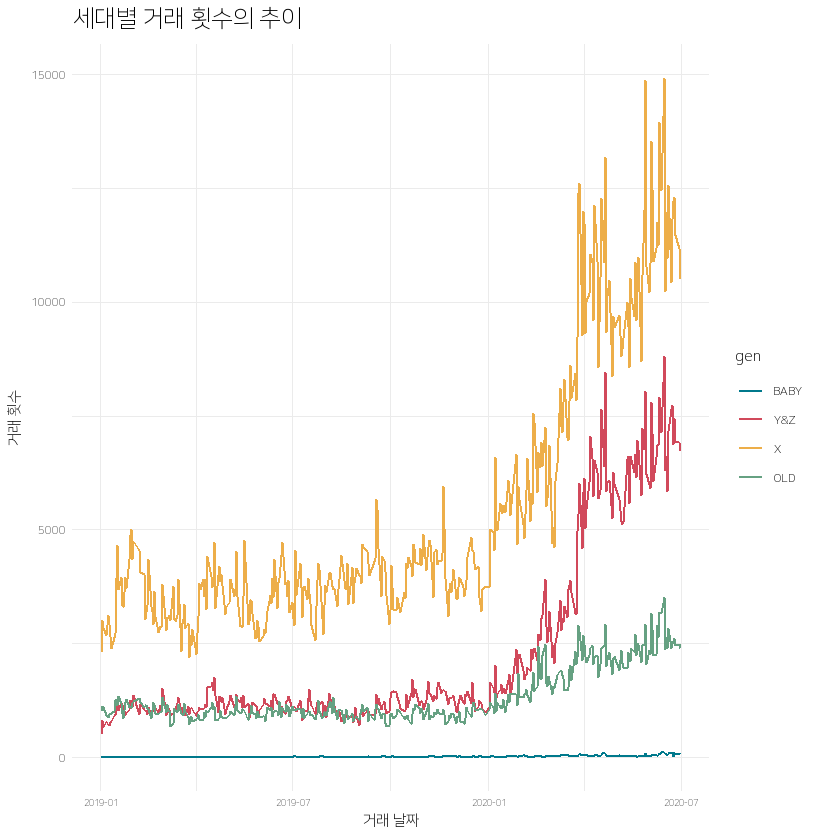

In [12]:
kr_dat %>% group_by(orr_dt, gen) %>% tally() %>% 
  ggplot(aes(x = orr_dt, y = n)) +
  geom_line(aes(color = gen), size = 0.8) +
  labs(x = "거래 날짜", y = "거래 횟수", title = "세대별 거래 횟수의 추이") +
  theme_minimal() +
  theme(plot.title = element_text(size = 18,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'),axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#00798c","#d1495b","#edae49","#66a182"))

- 세대별로 거래 횟수의 추이를 시각화해보니, X세대와 Y&Z세대가 가장 많이 증가하였습니다. 

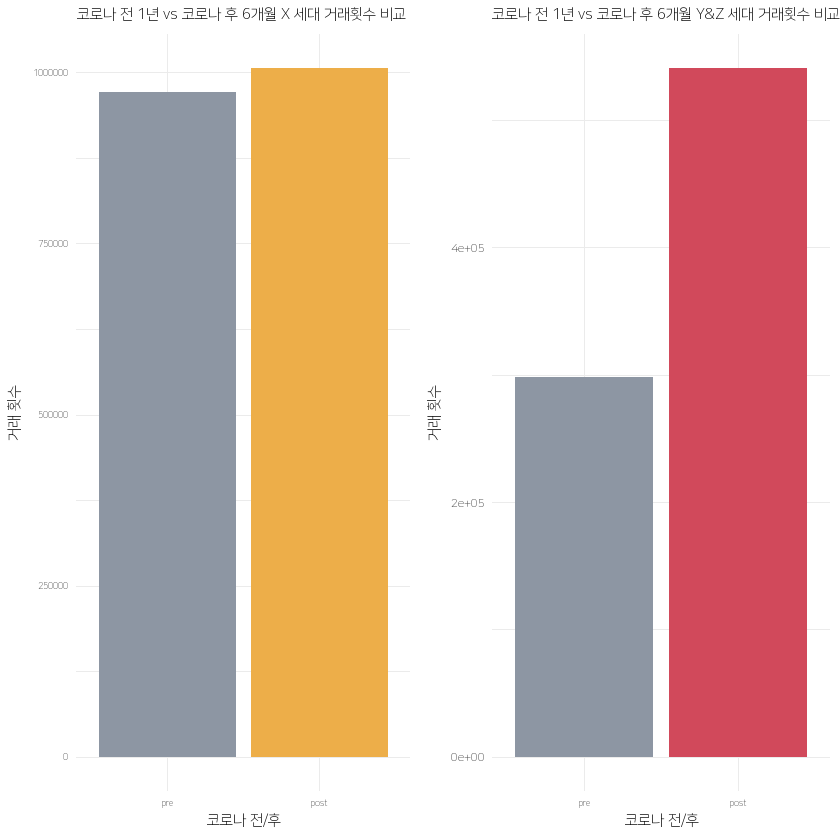

In [13]:
# 코로나 이전과 이후의 거래 횟수 비교
corona_X <- kr_dat %>% filter(gen=='X') %>% 
  mutate(corona=ifelse(orr_dt<'2020-01-20','pre','post'))
corona_X$corona <- factor(corona_X$corona,levels=names(sort(table(corona_X$corona),decreasing=FALSE)))
p1 <- corona_X %>% ggplot(aes(x=corona))+geom_bar(fill=c("#8d96a3","#edae49")) +
      ggtitle('코로나 전 1년 vs 코로나 후 6개월 X 세대 거래횟수 비교') +
      labs(x = "코로나 전/후", y = "거래 횟수") +
      theme_minimal() +
      theme(plot.title = element_text(size = 11,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
            text = element_text(face = "bold",family='square'),axis.text.y = element_text(size=7, family='square',face='bold'))

corona_YZ <- kr_dat %>% filter(gen=='Y&Z') %>% 
  mutate(corona=ifelse(orr_dt<'2020-01-20','pre','post'))
corona_YZ$corona <- factor(corona_YZ$corona,levels=names(sort(table(corona_YZ$corona),decreasing=FALSE)))
p2 <- corona_YZ %>% ggplot(aes(x=corona))+geom_bar(fill=c("#8d96a3","#d1495b")) +
      ggtitle('코로나 전 1년 vs 코로나 후 6개월 Y&Z 세대 거래횟수 비교') +
      labs(x = "코로나 전/후", y = "거래 횟수") +
      theme_minimal() +
       theme(plot.title = element_text(size = 11,family='square'), axis.text.x = element_text(size=7, family='square',face='bold'), 
            text = element_text(face = "bold",family='square'), axis.text.y=element_text(family='square',face='bold'))

rm(corona_X, corona_YZ)

grid.arrange(p1,p2, ncol = 2)

- X세대와 Y&Z세대의 거래 횟수를 코로나 발생 전후로 나누어 그린 그래프에서 알 수 있듯이, X세대는 코로나 이전에도 거래가 많았지만 Y&Z세대는 코로나 발생 이후로 급격하게 증가하였습니다.

#### - 세대별 유입 고객수 시각화

기존에 주식 거래를 한 경험이 있는 고객 외에 코로나 이후 새롭게 주식 시장에 유입된 고객의 수를 파악하고자 했습니다. <br>
2020년 이전에 계좌를 개설한 적이 있는 고객을 제외한 후, 2020년에 새롭게 유입된 고객들이 가장 처음 계좌를 개설한 날짜를 기준으로 시각화하였습니다.

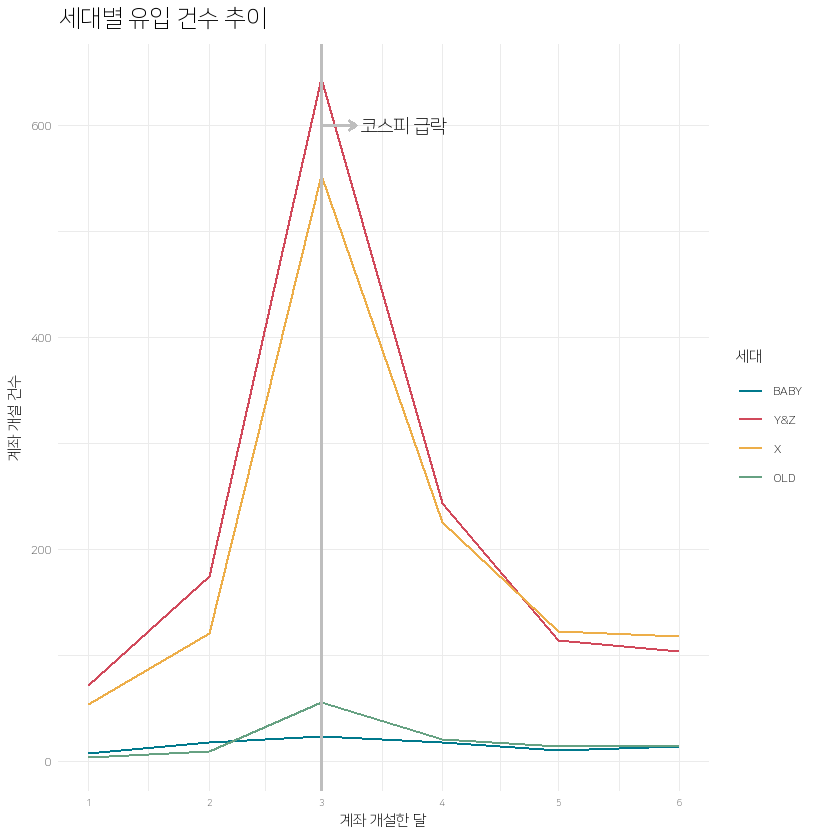

In [14]:
had_act <- kr_dat %>% group_by(cus_id, act_id, act_opn_ym) %>% tally() %>% filter(act_opn_ym < '2020-01-01') # 2020년 이전에 계좌를 개설한 적이 있는 고객 리스트


kr_dat[!(kr_dat$cus_id %in% had_act$cus_id),] %>% group_by(cus_id, gen) %>% arrange(act_opn_ym, .by_group = TRUE) %>%
  summarise(first_act = min(act_opn_ym)) %>% 
  ggplot(aes(x = first_act)) +
  geom_line(aes(color = gen), stat = 'count', size = 0.8) +
  labs(x = "계좌 개설한 달", y = "계좌 개설 건수", color = "세대", title = "세대별 유입 건수 추이") +
  theme_minimal() +
  theme(plot.title = element_text(size = 18,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#00798c","#d1495b","#edae49","#66a182")) +
  geom_vline(xintercept = ymd("2020-03-01"), size = 1, color = 'grey') +
  geom_segment(aes(x = ymd("2020-03-01"), xend = ymd("2020-03-10") , y = 600, yend = 600), size=1,
               arrow = arrow(length = unit(0.2,"cm")), color = "grey") +
  annotate("text", x = ymd("2020-03-10"), y = 600, label = "코스피 급락", size = 5, family='square',hjust = -0.05, vjust = 0.5)

rm(had_act)

- 대부분의 기간동안 Y&Z세대가 가장 많이 유입되었고, 특히 코로나로 인해 코스피 지수가 급락했던 3월에 가장 많이 유입되었습니다.

지금까지 전체 데이터를 통해 살펴본 주식 시장의 흐름을 보면, 코로나 이후로 전 세대에 걸쳐 주식 거래가 증가하고 새로운 고객들이 유입되었지만, 특히 Y&Z세대가 눈에 띄게 증가하였다는 것이 알 수 있습니다.<br>
이는 Y&Z세대가 앞으로의 주식 시장에서 전보다 훨씬 큰 영향력을 가질 것이라는 것을 의미합니다.<br>
따라서 저희 팀은 **Y&Z세대의 주식 투자가 어떠한 양상을 띄는지 집중적으로 분석** 하고, 이에 맞는 **새로운 상품 및 서비스를 제안** 하고자 합니다.

# 2. 본론

본격적인 분석에 앞서 저희 팀은 국내 거래 데이터와 해외 거래 데이터의 비율이 약 113:1로 국내 거래 데이터가 훨씬 큰 비중을 차지한다는 점과 해외 거래를 해본 고객의 수가 현저히 적다는 점을 이유로 **국내 거래 데이터에 집중**했습니다.<br><br>
그리고 19세 이하로 이루어진 'BABY'세대의 경우에는, 다른 세대에 비해 표본의 수가 너무 적어 전체적인 경향을 파악하기 힘들다고 판단해 **세대별 비교를 위한 시각화에서 제외**하였습니다.<br><br>
또한, 주식 거래의 횟수나 수량을 기준으로 시각화를 할 경우, 대부분의 분석에서 고객의 수가 가장 많은 'X세대'가 항상 큰 값을 가질 수 밖에 없기 때문에 **(해당 데이터/전체 데이터)인 비율로 시각화**를 진행하였습니다.<br><br>
마지막으로, 주식 거래의 수량이 다른 고객에 비해 압도적으로 많은 고객들과, 하나의 종목에 대해서만 많은 양을 거래한 고객들로 인해 전체적인 흐름이 왜곡된다고 판단하여 **이상치로 보고 제외**하였습니다.

이상치는 **1) 전체의 경우**와 **2) 전 기간동안 하나의 종목만 산 경우**를 나누어 IQR을 이용하여 구하였습니다.

<img src = "https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FboDTe4%2FbtqHP3beJxg%2F8mzOK0wWK31QXpaY7VDJRk%2Fimg.png" width = 500 align = "center">

다만 IQR은 대칭적인 분포일 때 정확한 이상치를 탐색할 수 있는데, 저희 데이터의 경우 한 쪽으로 치우친 양상을 띄기 때문에 $log$ 를 취해 정규분포에 가까운 모양으로 만들어주었습니다. <br>
즉, 위에서 말한 두 가지 경우에 대해 $log$ 를 씌운 값의 IQR을 통해 이상치를 구하였습니다.

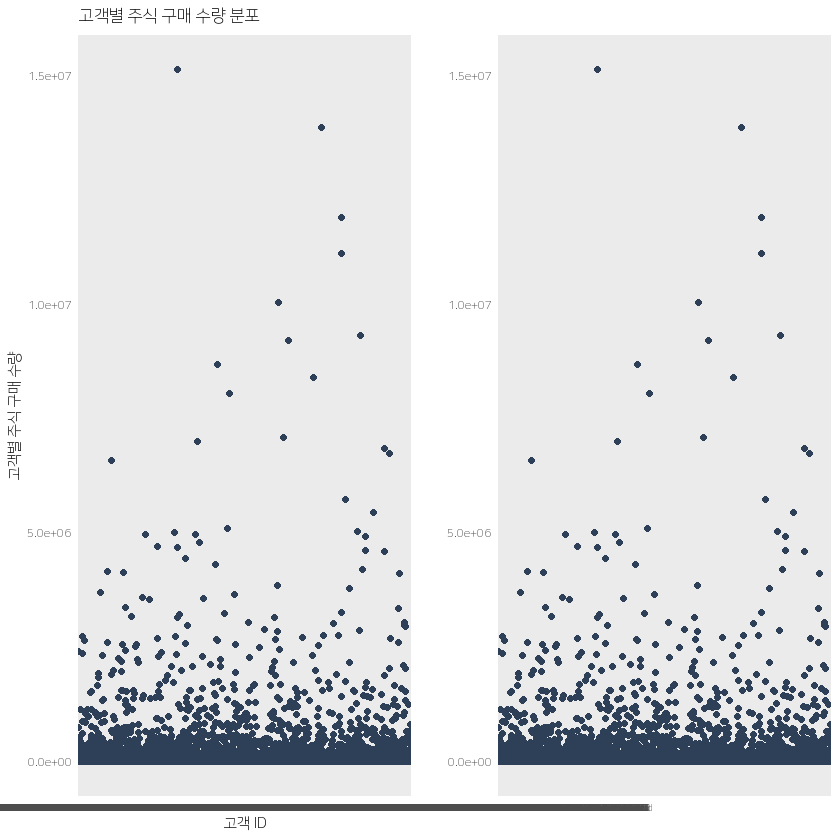

In [13]:
# 이상치를 구하는 함수
is_outlier <- function(x) {
  return(x < quantile(x, 0.25) - 1.5 * IQR(x) | x > quantile(x, 0.75) + 1.5 * IQR(x))}

# 1) 전체의 경우
outlier1 = kr_dat %>% group_by(cus_id) %>% summarise(total = sum(cns_qty)) %>% ungroup()

p1 <- outlier1 %>% ggplot(aes(x = cus_id, y = total)) + geom_point(color = "#2e4057") +
      labs(x = "고객 ID", y = "고객별 주식 구매 수량", title = "고객별 주식 구매 수량 분포") +
      theme_minimal() + 
       theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
            text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'))

outlier1 <- outlier1[which(is_outlier(log(outlier1$total))),] %>% filter(total != 1) %>% select(cus_id) %>% as.vector() 
# 이상치를 제거하는 목적이 '거래 수량이 비이상적으로 많은 고객'을 제거하는 것이었기 때문에 기존에 이상치로 뽑히던 '전체 거래 수량이 1인 고객'을 제외하고 이상치를 구했습니다.

kr_dat <- kr_dat[!(kr_dat$cus_id %in% outlier1$cus_id),]

p2 <- kr_dat %>% group_by(cus_id) %>% summarise(total = sum(cns_qty)) %>%
      ggplot(aes(x = cus_id, y = total)) + geom_point(color = "#2e4057") +
      labs(x = "고객 ID", y = "고객별 주식 구매 수량", title = "이상치 제거 후 고객별 주식 구매 수량 분포") +
      theme_minimal() +
       theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
            text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'))

grid.arrange(p1, p2, ncol = 2)

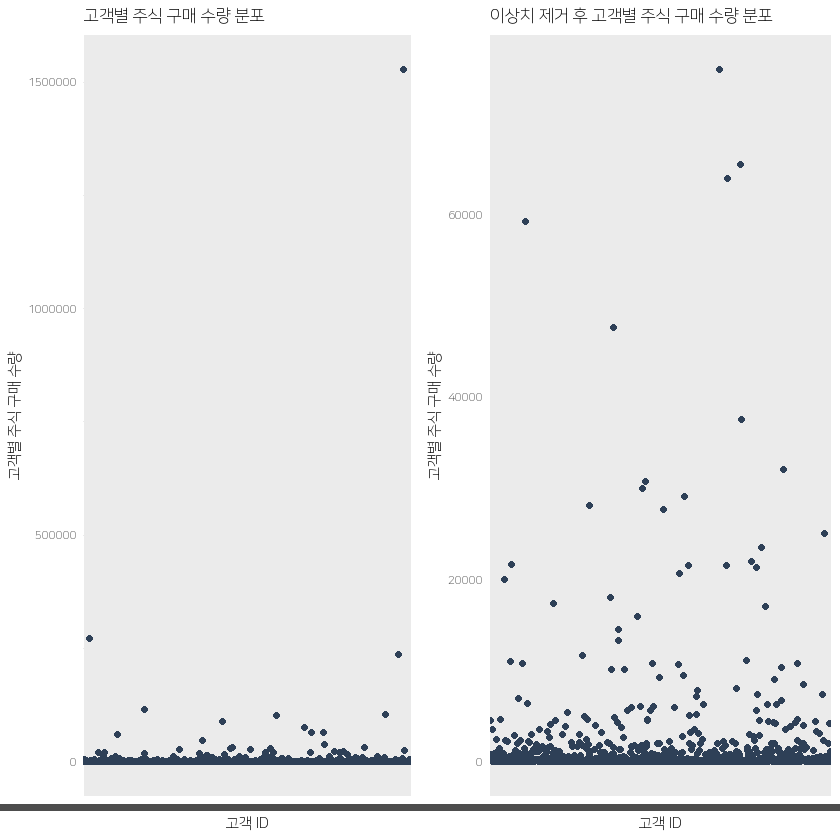

In [14]:
# 2) 하나의 종목만 산 경우
outlier2 <- kr_dat %>% group_by(cus_id, iem_krl_nm) %>% summarise(n = 1, total = sum(cns_qty)) %>% group_by(cus_id) %>% dplyr::summarise(company = sum(n), total = sum(total)) %>% filter(company <= 1) %>% ungroup()

p1 <- outlier2 %>% ggplot(aes(x = cus_id, y = total)) + geom_point(color = "#2e4057") +
  labs(x = "고객 ID", y = "고객별 주식 구매 수량", title = "고객별 주식 구매 수량 분포") +
  theme_minimal() +
  theme(plot.title = element_text(size = 13, family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'))

outlier2 <- outlier2[which(is_outlier(log(outlier2$total))),] %>% select(cus_id) %>% as.vector()

kr_dat <- kr_dat[!(kr_dat$cus_id %in% outlier2$cus_id),]

p2 <- kr_dat %>% group_by(cus_id, iem_krl_nm) %>% summarise(n = 1, total = sum(cns_qty)) %>% group_by(cus_id) %>% dplyr::summarise(company = sum(n), total = sum(total)) %>% filter(company <= 1) %>% 
  ungroup() %>%
  ggplot(aes(x = cus_id, y = total)) + geom_point(color = "#2e4057") +
  labs(x = "고객 ID", y = "고객별 주식 구매 수량", title = "이상치 제거 후 고객별 주식 구매 수량 분포") +
  theme_minimal() +
  theme(plot.title = element_text(size = 13, family='square'), axis.text.x = element_text(size=7, family='square',face='bold'), 
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square', face='bold'))

grid.arrange(p1, p2, ncol = 2)

저희가 제거한 이상치의 cus_id는 다음과 같습니다.

In [15]:
outlier1 %>% rbind(outlier2)

cus_id
<fct>
0291016d5fa63f348a0fc64993c9b1d5fdf8ad4a2905f46c60fab8fe17bb565a
2e641932f1d37c96b69990a0c96808ee85da4314b859fca36781e0ab3c15dbfc
6e7ec01fe6d9aac446fefc890bec2f5fcfce73077c232aca96f75dbaf4946706
9b85b4d1f2032ff2be874dae8341640fa694fea7608ac262a6350de129b70be5
ed09aa18392002839ab47b4cda2bfc7828310522e7960ba312987ce41c034dee
f947b0a101fcb29ce06f2a4592430122f56d17ffff40f0213e11b63506fc41e4
fac85402945988d071b46917d8c1326cdb066cc7170c464119263994f5bef08c


In [16]:
rm(is_outlier, outlier1, outlier2)

## 1. Y&Z세대의 특징

저희가 본 데이터 분석을 통해 정의한 Y&Z세대의 특징은 다음과 같습니다. <br>
- 간편함을 추구한다.
- 단기적인 수익성을 추구한다.
- 투자 상품에 대한 관심의 폭이 넓다. <br>

이러한 세 가지 특징을 어떻게 도출했는지에 대해 시각화와 함께 구체적으로 설명드리겠습니다.

### A. 간편함 추구

#### 주문 매체 관련 시각화

첫째로, 데이터를 통해 세대별로 주식 거래를 할 때 주로 어떤 주문 매체를 통해 거래를 하는지에 대해 알아보겠습니다.

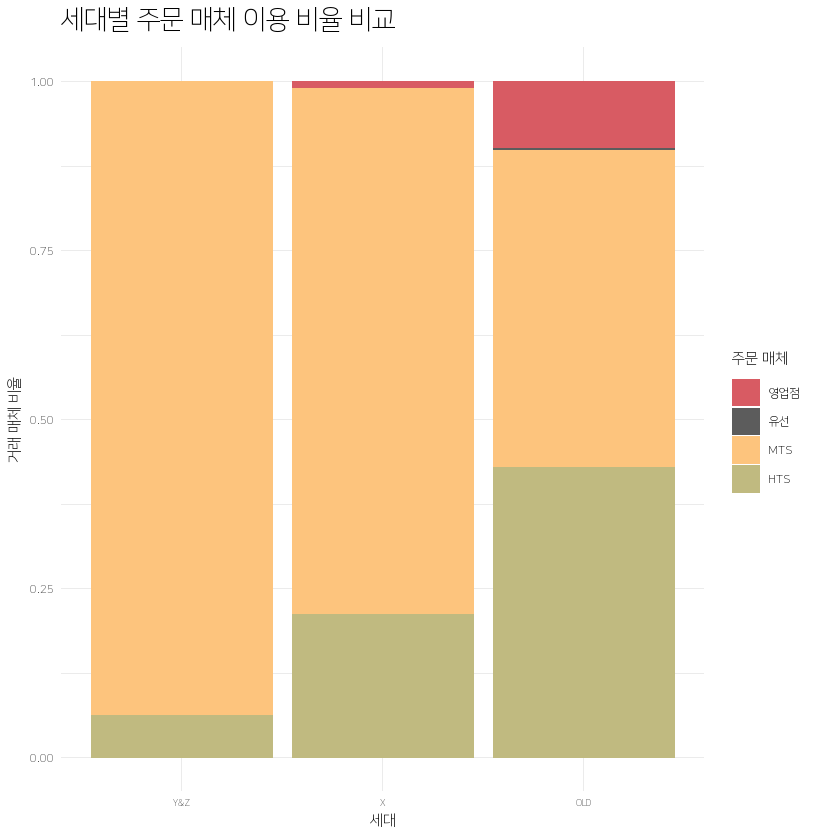

In [19]:
kr_dat %>% filter(gen != 'BABY') %>%  group_by(gen, orr_mdi_dit_cd) %>% tally() %>% 
  ggplot(aes(x = gen, y = n)) +
  geom_bar(aes(color = orr_mdi_dit_cd, fill = orr_mdi_dit_cd), stat = 'identity', position = 'fill')+
  labs(x = "세대", y = "거래 매체 비율", fill = "주문 매체", color = "주문 매체", title = "세대별 주문 매체 이용 비율 비교") +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, family='square'),axis.text.x = element_text(size=7, family='square',face='bold'),
        text = element_text(face = "bold", family='square'), axis.text.y = element_text(family='square', face='bold')) +
  scale_color_manual(values = c("#D85B63", "#5C5C5C", "#FDC47D","#C0BA80")) +
  scale_fill_manual(values = c("#D85B63", "#5C5C5C", "#FDC47D","#C0BA80"))

IT기술에 친숙한 디지털 세대인 Y&Z세대는, <br>
- **대부분의 거래가 모바일 매체**를 통해 이루어졌고 극히 일부만 인터넷 매체를 통해 이루어졌습니다. <br>
- 또한 다른 세대와 비교했을 때에도 **MTS 이용 비율이 현저히 높은 것**을 알 수 있습니다.

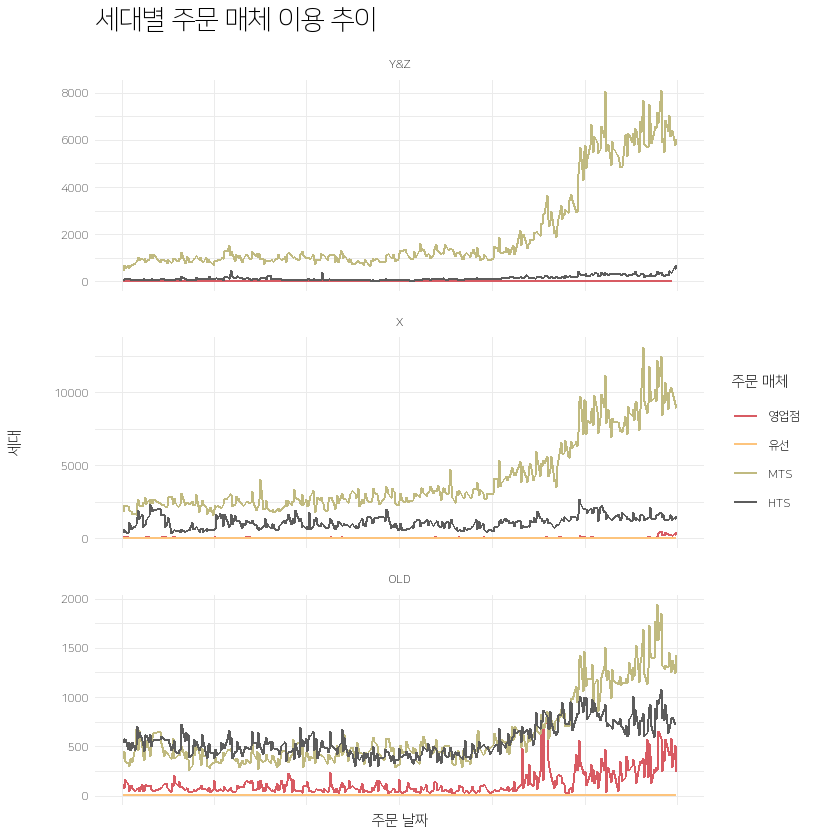

In [20]:
kr_dat %>% filter(gen != 'BABY') %>% group_by(gen,orr_dt,orr_mdi_dit_cd) %>% tally() %>% 
  ggplot(aes(x = orr_dt, y = n)) +
  geom_line(aes(color = orr_mdi_dit_cd), size = 0.8) +
  labs(x = "주문 날짜",y = "세대", color = "주문 매체", title = "세대별 주문 매체 이용 추이") +
  facet_wrap(~gen, scales="free", ncol = 1) +
  theme_minimal() +
  theme(plot.title = element_text(size = 20, family='square'),axis.text.x = element_blank(),
        text = element_text(face = "bold", family='square'), axis.text.y = element_text(family='square',face='bold'),
        legend.position = "right") +
  scale_color_manual(values = c("#D85B63","#FDC47D","#C0BA80", "#5C5C5C")) +
  scale_fill_manual(values = c("#D85B63", "#FDC47D","#C0BA80", "#5C5C5C"))

세대별로 주문 매체 이용 횟수의 추이를 보았을 때에도, Y&Z세대의 MTS 이용 횟수가 <br>
- HTS나 영업점 단말 등 다른 주문 매체와의 차이가 가장 크고
- 다른 세대에 비해 가파르게 상승하고 있습니다. <br>
- 이는 코로나 이후 유입된 Y&Z세대 고객들의 대부분이 거래에 MTS를 사용한다고 유추할 수 있습니다. <br><br>

따라서 유입된 Y&Z세대의 이탈을 막기 위해서는 **MTS를 통한 서비스 제공**이 활발히 이루어져야 합니다. <br>
특히 NH투자증권의 MTS인 '나무'가 이번 2020 아시아 투데이 금융대상 베스트 MTS상을 수상한 만큼 **본사의 MTS를 이용한 서비스**를 통해 새로운 Y&Z세대의 유입이 가능할 것이라고 생각합니다.

#### 관심 종목 관련 시각화

둘째로, 주식 종목의 대분류를 기준으로 세대별로 관심있는 종목을 찾고자 했습니다.

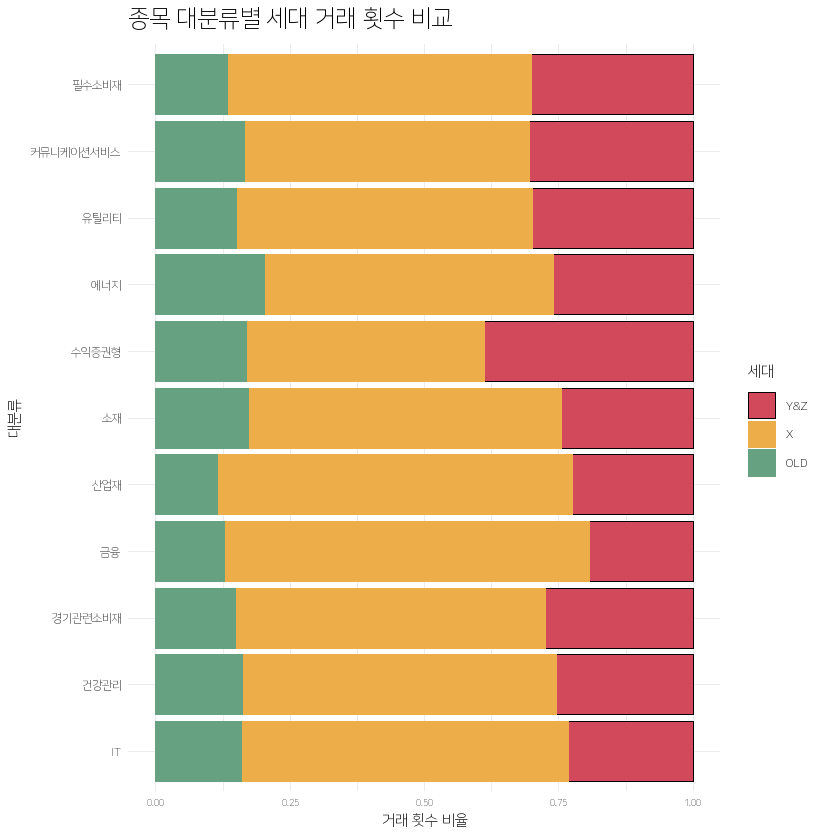

In [21]:
kr_dat %>% filter(gen != 'BABY', big_cat != '미분류') %>% group_by(big_cat, gen) %>% tally() %>% 
  ggplot(aes(x = big_cat, y = n)) +
  geom_bar(aes(fill = gen, color = gen), stat = 'identity', position = 'fill') +
  coord_flip() +
  labs(x = "대분류", y = "거래 횟수 비율", color = "세대", fill = '세대', title = "종목 대분류별 세대 거래 횟수 비교") +
 theme_minimal() +
  theme(plot.title = element_text(size = 18, family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold", family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("black","#edae49","#66a182")) +
  scale_fill_manual(values = c("#d1495b","#edae49","#66a182"))

- 대부분의 대분류에 대해 고객의 수가 더 많은 X세대가 가장 큰 비율을 차지하고 있습니다.
- 다만, **수익증권형**의 경우 Y&Z세대가 X세대와 거의 비슷한 수준으로 거래하고 있다는 것을 알 수 있습니다.
- 모든 대분류 중에서도 Y&Z세대가 가장 큰 비율을 차지하는 것은 **수익증권형**입니다.

수익증권형의 *거래 규모(거래 수량 X 체결 가격)* 에 대한 세대별 차이도 알아보기 위해 종목의 type에 대한 시각화를 진행했습니다. <br>
저희의 목적은 **수익증권형에 대한 거래 규모**를 보는 것이었기 때문에 '일반주식'은 제외하고 시각화하였습니다.

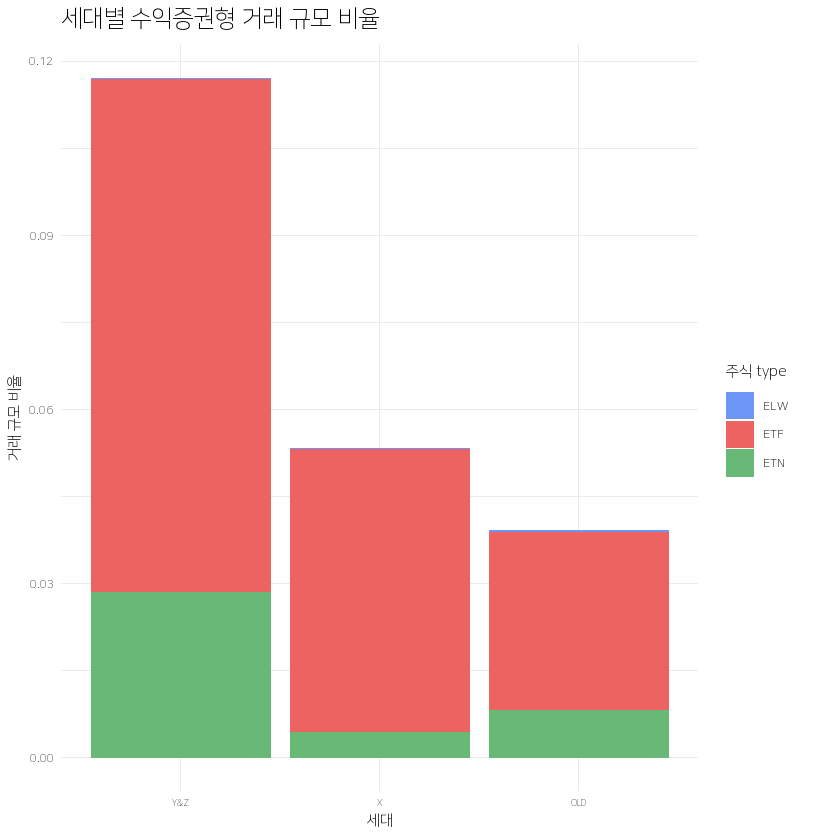

In [22]:
kr_dat %>% filter(gen != 'BABY') %>% group_by(gen) %>%  mutate(total = sum(cns_qty*orr_pr)) %>%
    group_by(gen, type) %>%
    summarise(n = sum(cns_qty*orr_pr), total = n/total) %>% unique() %>% filter(type != '일반주식') %>% #전체 거래 규모 중 수익증권형의 거래 규모 비율
    ggplot(aes(x = gen, y = total)) +
    geom_bar(aes(color = type, fill = type),stat="identity") +
    labs(x = "세대", y = "거래 규모 비율", color = "주식 type", fill = '주식 type', title = "세대별 수익증권형 거래 규모 비율") +
    theme_minimal() +
    theme(plot.title = element_text(size = 18, family='square'), axis.text.x = element_text(size=7, family='square',face='bold'),
          text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) + 
    scale_color_manual(values = c("#6B96F6", "#EC6362","#67B975")) +
    scale_fill_manual(values = c("#6B96F6", "#EC6362","#67B975"))

- Y&Z세대가 수익증권형에 대한 거래 규모 비율이 가장 큽니다.
- 특히, ETF와 ETN 모두에 대해서 다른 세대와 비교했을 때 2배 이상의 차이가 나는 것을 알 수 있습니다.
- 이는 Y&Z세대가 다른 세대에 비해 수익증권형 주식에 대해 더 많은 금액을 투자한다는 것을 의미합니다.
- 다만 ELW의 경우, 전 세대에 걸쳐 매우 적은 투자가 이루어지는 것으로 보입니다.

다음으로 시간에 따른 세대별 **수익증권형에 대한 관심**을 알아보고자 했습니다. <br>
다만 코로나 이후 전체적인 거래가 증가했기 때문에 비교를 위해 **KOSPI 상위 30개의 종목**을 '우량주'로 정의하고 함께 시각화하였습니다.<br>
이 때 사용한 단위 또한 '거래 규모의 비율'입니다.

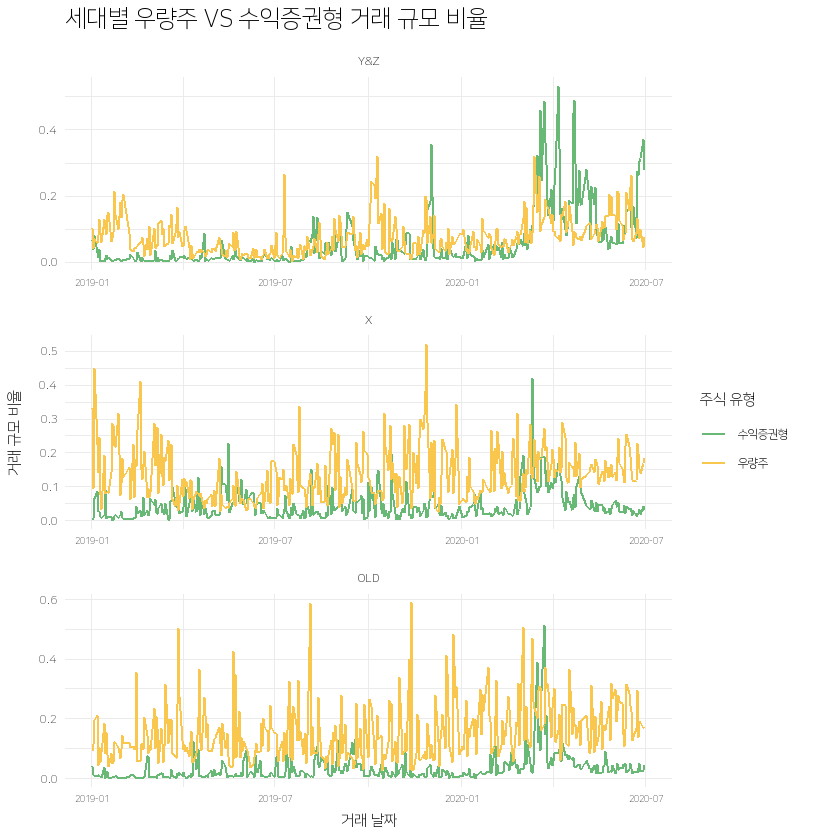

In [23]:
top30 = c('삼성전자보통주','에스케이하이닉스보통주', 'LG화학보통주','삼성전자1우선주 ',
          '삼성바이오로직스보통주','셀트리온보통주','NAVER보통주','현대자동차보통주',
          '삼성SDI보통주', '카카오보통주', "LG생활건강보통주", "삼성물산보통주","기아자동차보통주", 
          "현대모비스보통주","포스코보통주",  "SK텔레콤보통주", "엔씨소프트보통주",  "KB금융지주 보통주", 
          "한국전력공사보통주","신한금융지주회사보통주", "SK보통주","SK이노베이션 보통주","삼성생명보험보통주",
          "LG보통주","삼성에스디에스보통주", "삼성전기보통주",   "케이티앤지보통주" ,"아모레퍼시픽 보통주" ,
          "LG화학1우선주" ,"현대자동차1우선주", "현대자동차3우선주(신형)","현대자동차2우선주(신형)", "삼성SDI1우선주",
          "LG생활건강1우선주","삼성물산1우선주(신형)", "SK1우선주","SK이노베이션 1우선주","LG1우선주", "삼성전기1우선주",
          "아모레퍼시픽 1우선주")## 시가 총액 기준 30위, 30위까지의 시가총액은 큰 변동이 없다고 가정

diff <- kr_dat
diff %<>% mutate(class = ifelse(iem_krl_nm %in% top30, "우량주",
                                ifelse(category=="수익증권형", "수익증권형", "그 외")),
                 total_price = cns_qty*orr_pr)
diff %<>% 
  group_by(gen, orr_dt) %>% 
  mutate(total_cns = sum(cns_qty),
         total_pr = sum(total_price)) %>% ungroup()

# 모든 세대 한번에 보기
diff %>% filter(gen!="BABY"& class!="그 외") %>% 
  group_by(gen, orr_dt, class) %>% 
  summarise(ratio = sum(total_price)/total_pr) %>% 
  ggplot(aes(x=orr_dt, y=ratio))+
  geom_line(aes(color=factor(class)), size = 0.7)+
  facet_wrap(~gen, scales="free", ncol = 1)+
  labs(x = "거래 날짜", y = "거래 규모 비율", color = "주식 유형", title = "세대별 우량주 VS 수익증권형 거래 규모 비율") +
 theme_minimal() +
  theme(plot.title = element_text(size = 18, family='square'), axis.text.x = element_text(size=7, family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#67B975", "#FAC74E"))

rm(diff)

- X세대와 OLD세대는 모든 시점에 대해 우량주가 계속해서 우세한 경향을 보입니다.<br>
- 반면, Y&Z세대는 코로나로 인한 유입이 늘어난 시점부터 수익증권형의 거래 규모 비율이 늘어나더니 3월부터는 **수익증권형이 우량주의 거래 규모를 뛰어넘는 모습**을 보입니다.

지금까지의 수익증권형 관련 시각화를 보면, Y&Z세대가 다른 세대와 차별화된 투자 양상을 보이는 관심 종목이 **'수익증권형'**, 그 중에서도 특정 지수의 수익률과 연동해서 움직이는 **ETF**와 **ETN**이라는 것을 유추할 수 있습니다. <br>
ETF와 ETN은 시장지수나 산업 지수, 각종 테마지수 등을 따르는 다양한 상품이 존재하기 때문에, 하나의 주식을 구매함으로써 여러 상품에 투자하는 효과를 누릴 수 있다는 장점이 있습니다.

<img src = "https://user-images.githubusercontent.com/52098204/103389441-28de7080-4b52-11eb-961b-95fd418459ad.png" width = 800 align = "center">

<br><br>
결론적으로 저희는 **1) MTS를 이용한 주식 거래 선호**와 **2) ETF, ETN과 같은 수익증권형 주식에 관심** 이라는 두 가지 인사이트를 통해, Y&Z세대가 **"간편함"** 을 추구한다고 판단했습니다.<br>
즉, Y&Z세대는 MTS를 이용함으로써 언제 어디서나 스마트기기를 통해 쉽게 주식을 사고 팔고, 여러 종목의 주식을 각각 매매하기보다 하나의 ETF나 ETN 상품을 통해 간편하게 분산투자 효과를 보고자 하는 것입니다.<br><br>
#### **따라서 간편하게 투자할 수 있는 상품이 Y&Z세대의 관심을 끌 수 있다고 생각합니다.**

### B. 단기적 수익성 추구

#### 주식 보유일 시각화

첫째로, 세대별 평균적인 주식 보유일의 분포가 어떻게 이루어져 있는지 알아보겠습니다. 이때 보유일은 주어진 데이터를 이용하여 계좌별, 종목별로 계산을 했습니다. 

In [ ]:

options(dplyr.summarise.inform = FALSE)

act_id_dat<-unique(kr_dat$act_id)

DATA2<-data.frame(act_id=NULL,
                  period=NULL,
                  iem_cd=NULL,
                 stringsAsFactors=FALSE)

for(i in 1:length(act_id_dat)){
  ACT_ID=act_id_dat[i] # 유니크한 act_id i번째 값
  first_dat = kr_dat %>% filter(act_id==ACT_ID) %>% # 해당 계좌의 모든 거래 데이터
    group_by(orr_dt,iem_cd,sby_dit_cd) %>% # 날짜별 + 종목별로 매도/매수 나눠서 그룹화
    summarise() %>% arrange(orr_dt) # 날짜 순으로 정렬 
  iem_dat = unique(first_dat$iem_cd) # 해당 계좌가 거래한 모든 종목(유니크 처리해서 중복 없음)
  PERIOD=rep(NA,length(iem_dat)) # 각 종목마다 보유일 계산해야되니까 그만큼을 NA 처리
  code=NULL 
  for(j in 1:length(iem_dat)){
    CODE=iem_dat[j] # 해당계좌가 거래한 j번째 종목
    second_dat = first_dat %>% filter(iem_cd==CODE) %>% 
      group_by(orr_dt,iem_cd,sby_dit_cd) %>% summarise() %>% arrange(orr_dt) 
    # 해당계좌가 거래했던 j번째 종목에 대한 거래 데이터에서 날짜랑 종목코드 가져옴
    sec_sell_date = second_dat %>% filter(sby_dit_cd=='매도') # 위 데이터에서 매도 데이터만 가져옴
    sec_buy_date = second_dat %>% filter(sby_dit_cd=='매수') # 위 데이터에서 매수 데이터만 가져옴
    buy_date = sec_buy_date$orr_dt # 매수 데이터의 orr dt -> 해당계좌의 해당 종목 매수일 벡터
    sell_date = sec_sell_date$orr_dt # 매도 데이터의 orr dt -> 해당계좌의 해당 종목 매도일 벡터
    idx1 = which(sell_date<buy_date[1]) # 매도 날짜 중 첫 매수일보다 먼저인 obs의 인덱스
    # 사기도 전에 파는 경우는 상식적으로 존재불가. (2019년 1월 이전에 매수한 주식이 없다고 가정)
    if(length(idx1)>0)sell_date = sell_date[-idx1] # 따라서 그러한 obs가 있을 경우는 제외하고 계산
    if(length(buy_date)==0) { # 산 적이 아예 없는데 데이터가 있다는 건 매도거래만 존재한다는 것. 위 가정에 따라 stranger로 취급
      PERIOD[j]='stranger' # 해당 종목의 보유일 = stranger (이상치 취급)
      code=c(code,CODE) # 그 종목코드 저장후
      next} # 다음 종목으로 pass
    untilnow=NULL
    if(length(sell_date)==0){ # 사기만 하고 판적이 없는 경우
      untilonly=NULL # 종목마다 untilonly 변수 초기화
      code=c(code,CODE) # 해당 종목코드 저장 후 
      for(l in 1:length(buy_date)){
        untilonly_one=difftime(as.Date('2020-06-30',
                                       format='%Y-%m-%d'),
                               buy_date[l]) # 산 날짜와 데이터 종료 기간인 2020년 6월 30일의 날짜차이 계산해서 
        # untilonly_one 변수에 저장하고
        untilonly=c(untilonly,untilonly_one)} # 모든 매수 날짜에 대해 날짜 차이(즉 보유일)을 구해준 뒤 untilonly에 저장
      PERIOD[j]=mean(untilonly) # j번째 종목에 대한 보유일 = untilonly의 평균이 됨
      next # 다음 종목으로 pass
    }
    if(length(buy_date[which(buy_date>max(sell_date))])>0){
      # 가장 최근에 판 날짜보다 산 날짜가 더 늦은(더 최신) 경우가 있다면 아직 안 판 주식이 남아있다는 증거라고 가정
      # 따라서 아직 팔지 않은 주식에 대한 보유일 계산 필요
      date=buy_date[which(buy_date>max(sell_date))] # 아직 팔지 않은 주식의 매수날짜
      for(m in 1:length(date)){ # 그 매수날짜(들)과 2020년 6월 30일의 날짜차이를 구함
        untilonly_one=difftime(as.Date('2020-06-30',
                                       format='%Y-%m-%d'),
                               date[m])
        untilnow=c(untilnow,untilonly_one) # untilnow 변수에 그 보유일 추가
        # 위 if문은 사기만 한 경우에 untilnow에 담기는 거고 그 보유일계산 끝나면 다음 종목으로 넘어감
      }
    }
    # 이제 sell_date을 기준으로 그 sell_date와 가장 가까운 매수날짜를 구해 두 날짜의 차를 보유일로 취급할것임
    # ex) 2020년 3월 2일에 해당 주식을 팔았다는 기록(=sell_date)이 있고
    #     2020년 2월 1일, 2월 20일에 해당 주식을 샀다는 기록이 있다면
    #     2020년 3월 1일과 가장 가까운 과거인 2월 20일을 매수날짜로 보고 보유일을 11일로 계산
    # why 가장 가까운 과거? 가장 최신에 산 주식을 가장 빨리 판다고 가정했음(사고 판 주식의 수량을 모두 고려할 수 없기 때문에) 
    len = length(sell_date) # 몇 번 팔았는지 = len
    period=NULL
    for (k in 1:len){
      sell_dat = sell_date[k] # k번째에 해당하는 매도 날짜
      diff=difftime(sell_dat,buy_date) %>% as.integer() # 그 매도 날짜와 모든 매수일의 차이일 계산
      if(length(diff)==0) next 
      per = min(diff[which(diff>=0)]) # 차이일이 0이상인 값 중에서(0 이하는 과거에서 미래를 뺀 거라서 안됨) 최솟값 
      period = c(period,per) # period 변수에 해당 보유일 추가
    }
    PERIOD[j]=mean(c(period,untilnow)) # j번째 종목의 모든 보유일의 평균 = j번째 종목의 보유일
    code=c(code,CODE) # 종목코드 저장
  }
  final_data = data.frame(act_id=rep(ACT_ID,length(PERIOD)), # length(PERIOD) = 해당 계좌가 산 종목 개수를 의미
                          period=PERIOD, # 보유일 넣고
                          iem_cd=code,
                 stringsAsFactors=FALSE) # 해당 보유일의 종목코드도 넣어줌
  DATA2<-rbind(DATA2,final_data,
                 stringsAsFactors=FALSE) # 지금까지의 데이터와 합체 후 다음 act_id로 
}


*(코드 돌아가는 시간이 너무 오래걸려 미리 저장해놓은 데이터를 불러왔습니다. 추후에 수정 가능하다면 수정하겠습니다!)*

In [17]:
DATA2 = fread('DATA_period_real_final.csv')
DATA2 %>% head()

act_id,period,iem_cd
<chr>,<chr>,<chr>
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,1,A001060
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,28,A215600
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,4,A000890
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,37.8888888888889,A000100
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,22,A045390
6caf4de40251d37cbba310f0c6dd0ed8f4c7ca4ccfa67560534c60f7d2da3332,stranger,A102940


계좌별로 각각의 상품에 대해 구한 보유일을 고객 단위로 평균을 낸 후, 4분위수를 이용해 평균 보유기간을 4개로 범주화하였습니다. 그 중에서 2일 미만의 평균 보유기간은 초단타형에 해당한다고 판단하여 새로운 범주로 추가하여 시각화를 진행하였습니다. 

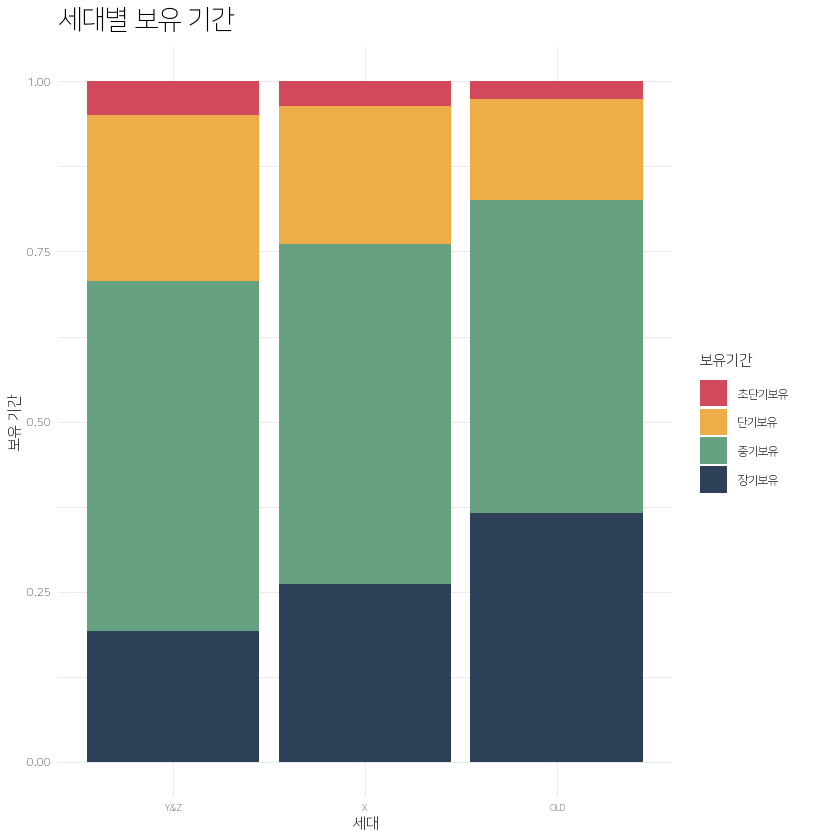

In [18]:
DATA2 %<>% filter(period != 'stranger')
DATA2$period %<>% as.numeric()
cus_info <- kr_dat %>% select(act_id, cus_id, gen, act_opn_ym) %>% unique()
period_dat = left_join(DATA2, cus_info, by = c("act_id" = 'act_id')) 
period_dat %>% filter(gen!="BABY") %>% group_by(cus_id,gen) %>%
  summarise(mean_period=mean(period)) %>% ungroup() %>%
  mutate(period_q = factor(ifelse(mean_period<2, 0, quantcut(mean_period, q=c(0, 0.25, 0.75,1))),labels=c("초단기보유", "단기보유", "중기보유", "장기보유"))) %>% 
  ggplot()+
  geom_bar(aes(x=gen, fill=factor(period_q)), position="fill")+
  labs(x="세대", y="보유 기간", title="세대별 보유 기간", fill="보유기간")+
  theme_minimal()+
  theme(plot.title = element_text(size = 20, family='square'),axis.text.x = element_text(size=7, family='square',face='bold'),
        text = element_text(face = "bold", family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#d1495b", "#edae49","#66a182","#2e4057","#00798c")) +
  scale_fill_manual(values = c("#d1495b", "#edae49","#66a182","#2e4057","#00798c"))
  


- Y&Z세대에서 평균 보유기간이 2일 미만으로, 단타형 거래를 주로하는 고객의 비율이 가장 높았습니다. <br>
- 평균보유기간 분포의 제 1사분위수에 해당하는 8.67일 이하의 보유기간을 가진 고객의 비율도 Y&Z세대에서 가장 높았습니다. <br>
- 평균 보유기간 분포의 제 3사분위수에 해당하는 47.4일 초과에 해당하는 고객은 OLD, X, Y&Z 순으로 많았습니다.<br>
- 다른 세대에 비해 **Y&Z세대가 짧은 보유일에 높은 비율로 분포해있음을 알 수 있습니다.**

#### 회전율 시각화

둘째로, 매매 회전율에 대해 알아보겠습니다. 개인투자자의 매매회전율은 투자금대비 거래금액을 의미하는 것으로, 회전율이 높으면 단타매매 위주로 운용되었을 가능성이 큰 것으로 알려져있습니다. 일반적으로 매매 회전율은 다음 식으로 계산이 됩니다. 

## $\frac{거래금액(매수, 매도)}{투자금액}$ $*$ $100%$

하지만 현재 주어진 상황에서 고객이 보유하고 있는 투자금을 정확하게 알 수 없으므로 투자금을 주어진 기간내의 총 매수금으로 가정하였습니다. 또, 보유일과 마찬가지로 정확한 투자금액 산정을 위하여 2019년 1월 1일 이후 개설된 계좌를 대상으로만 회전율을 계산했습니다. 

In [20]:
make_turnover = function(generation) {
  # Y&Z 세대이고, 2019년 1월 이후 계좌를 만든 사람을 필터링합니다.
  gen_dat<-kr_dat %>% filter(act_opn_ym>="2019-01-01") %>%
    filter(gen==generation) %>%
    group_by(cus_id) %>%
    summarise(n=n())
  
  gen_dat$turnover=rep(NA,nrow(gen_dat))
  kr_dat_new<-kr_dat %>% filter(act_opn_ym>="2019-01-01")
  for(i in 1:nrow(gen_dat)){
    cus_id = gen_dat$cus_id[i]
    idx = which(kr_dat_new$cus_id==cus_id)
    data = kr_dat_new[idx,]
    data = data %>% arrange(orr_dt)
    if(data$sby_dit_cd[1]=="매도"){
      gen_dat$turnover[i]='stranger'
      next
    }
    datetime = data$orr_dt %>% unique()
    
    sell_dat<-data %>% filter(sby_dit_cd=="매도")
    buy_dat <-data %>% filter(sby_dit_cd=="매수")
    
    sell_amt<-sum(sell_dat$cns_qty*sell_dat$orr_pr)
    buy_amt<-sum(buy_dat$cns_qty*buy_dat$orr_pr)
    
    # 투자 금액은 매수 금액과 같다고 가정합니다. 
    invest_amt = buy_amt
    turnover = ((sell_amt+buy_amt)/invest_amt*100)/2
    gen_dat$turnover[i]=turnover
  }
  return(gen_dat)
  
}
BABY = make_turnover("BABY")
YandZ = make_turnover("Y&Z")
X = make_turnover("X")
OLD= make_turnover("OLD")

# 세대별 회전율 평균 비교
mean(ifelse(BABY$turnover=='stranger',0,BABY$turnover) %>% as.numeric())

mean(ifelse(OLD$turnover=='stranger',0,OLD$turnover) %>% as.numeric())

mean(ifelse(X$turnover=='stranger',0,X$turnover) %>% as.numeric())

mean(ifelse(YandZ$turnover=='stranger',0,YandZ$turnover) %>% as.numeric())

# YZ의 회전율이 제일 높다!

BABY$gen=rep('BABY',nrow(BABY))
YandZ$gen=rep('Y&Z',nrow(YandZ))
X$gen=rep('X',nrow(X))
OLD$gen=rep('OLD',nrow(OLD))

final_dat=rbind(BABY,YandZ,X,OLD)

##################################################################
# 고객당 월별 회전율 만들기
make_turnover_bymonth = function(generation){
  totalmonth=substr(unique(kr_dat$orr_dt),1,7) %>% unique()
  gen_cus = kr_dat %>% filter(act_opn_ym>="2019-01-01") %>%
      filter(gen==generation) %>%
      group_by(cus_id) %>%
      summarise(n=n())
  gen_dat<-data.frame(cus_id=rep(gen_cus$cus_id,
                                each=length(totalmonth)),
                     n=rep(gen_cus$n,
                           each=length(totalmonth)))
  gen_dat$turnover_month<-rep(NA,nrow(gen_dat))
  
  for(i in 1:nrow(gen_cus)){
    cus_id = gen_cus$cus_id[i]
    idx = which(kr_dat$cus_id==cus_id)
    data = kr_dat[idx,]
    data = data %>% arrange(orr_dt)
    data$month = substr(data$orr_dt,1,7)
    
    if(data$sby_dit_cd[1]=="매도"){
      idx2 = which(gen_dat$cus_id==cus_id)
      gen_dat$turnover_month[idx2]='stranger'
      next
    }
    
    total_buy_amt = 0
    for(j in 1:length(totalmonth)){
      dat_month<-data %>%
        filter(month==totalmonth[j])
      if(nrow(dat_month)==0){
        gen_dat$turnover_month[(i-1)*18+j]='No deal'
        next
      }
      
      sell_dat<-dat_month %>% 
        filter(sby_dit_cd=="매도")
      buy_dat <-dat_month %>% 
        filter(sby_dit_cd=="매수")
      
      sell_amt<-sum(sell_dat$cns_qty*sell_dat$orr_pr)
      buy_amt<-sum(buy_dat$cns_qty*buy_dat$orr_pr)
      total_buy_amt = total_buy_amt + buy_amt
      
      invest_amt = total_buy_amt
      turnover = ((sell_amt+buy_amt)/invest_amt*100)/2
      
      gen_dat$turnover_month[(i-1)*18+j]=turnover
      
    }
  }
  
  gen_dat<-gen_dat %>% mutate(turnover_month=ifelse((
    turnover_month=='No deal'|turnover_month=='stranger'),NA,turnover_month))
  gen_dat$turnover_month<-as.numeric(gen_dat$turnover_month)
  
  month=c('20190101','20190201','20190301','20190401',
          '20190501','20190601','20190701','20190801',
          '20190901','20191001','20191101','20191201',
          '20200101','20200201','20200301','20200401',
          '20200501','20200601')
  gen_dat$month<-rep(month)
  
  gen_dat$month<-as.Date(gen_dat$month,
                        format = "%Y%m%d")
  gen_dat$gen = rep(generation, nrow(gen_dat))
  
  gen_dat2 = gen_dat %>% 
    mutate(turnover_month=as.numeric(turnover_month)) %>% 
    group_by(month) %>% drop_na() %>% 
    summarise(mean_TO=mean(turnover_month))
  gen_dat2$gen = generation
  
  return(gen_dat2)
}

BABY3 = make_turnover_bymonth("BABY")
YandZ3 = make_turnover_bymonth("Y&Z")
X3 = make_turnover_bymonth("X")
OLD3 = make_turnover_bymonth("OLD")

ALL = rbind(YandZ3,X3,OLD3,BABY3)

[1] 59.26797

[1] 71.48154

[1] 75.80618

[1] 77.03011

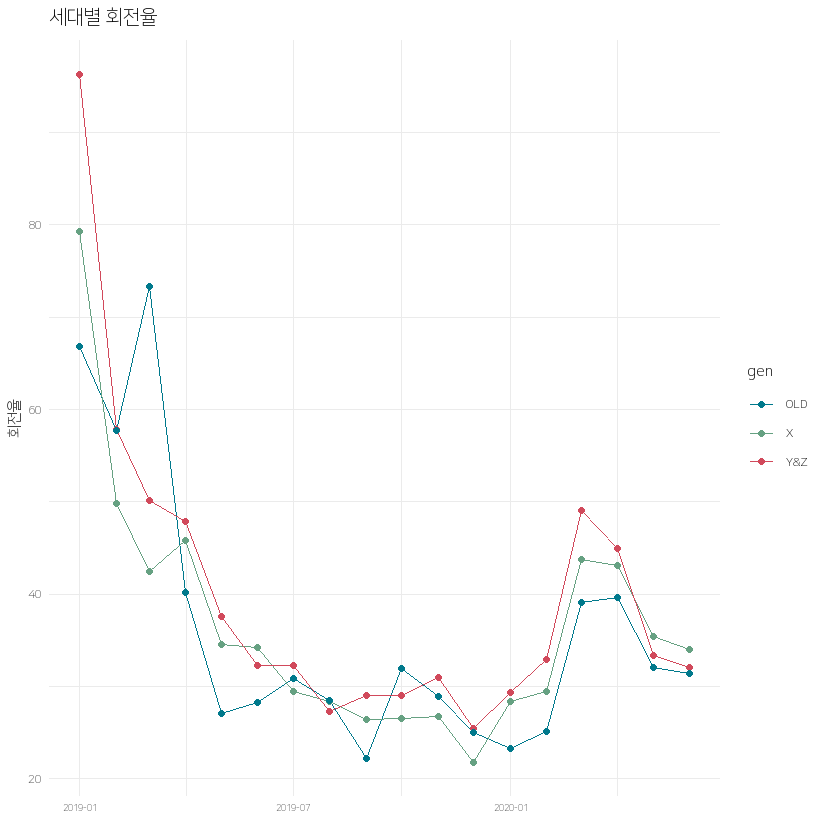

In [21]:
ALL %>% filter(gen!="BABY") %>% 
  ggplot(aes(x=month,y=mean_TO))+
  geom_line(aes(color=gen))+
  geom_point(aes(color=gen))+
  labs(x="", y="회전율", title="세대별 회전율", fill="세대")+
  theme_minimal()+
  theme(plot.title = element_text(size =15, family='square'),axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#00798c","#66a182","#d1495b")) +
  scale_fill_manual(values = c("#00798c","#66a182","#d1495b"))

** 달별 누적 회전율이므로 2019년 초의 값은 적은 관측치 수로 계산되어 불안정한 값을 가집니다.
- 2020년 1월 이전은 모든 세대의 회전률 값이 교차하며 비슷한 수준을 보이는 듯 하지만, **Y&Z 세대의 회전율이 전반적으로 더 높은 값**을 가지고 있습니다.
- 2020년 1월 이후 부터 명확하게 Y&Z세대의 회전율이 다른 세대의 회전율보다 더 큰 값을 가집니다. 
- 2020년 4월 전 세대에 걸쳐 회전율이 급증하고, 그 중에서도 **Y&Z가 가장 크게 증가**하였습니다. 

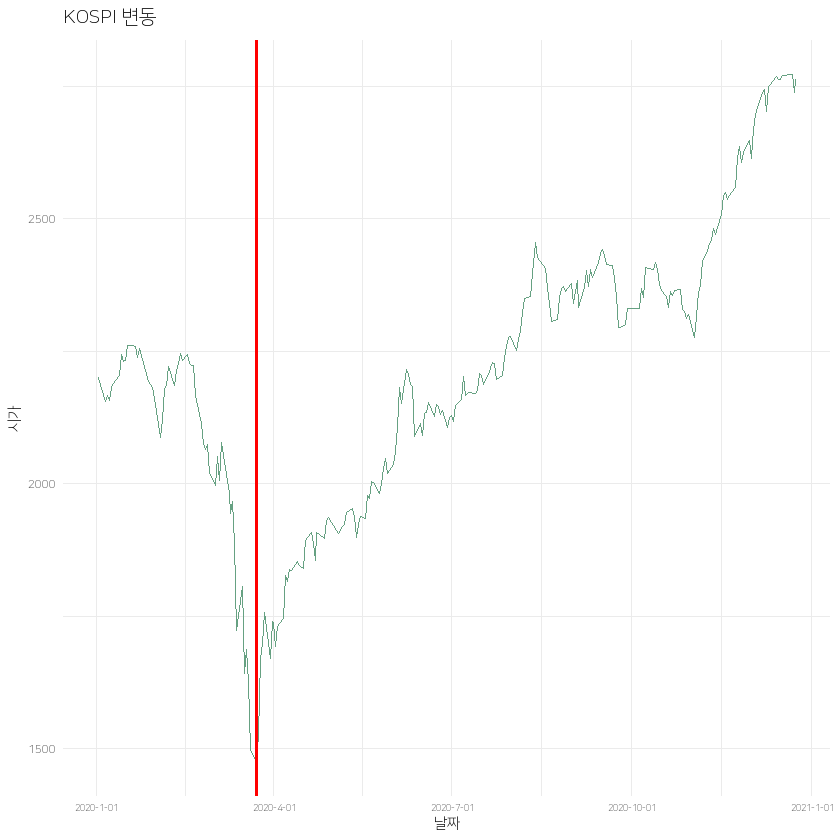

In [24]:
setwd(paste0(getwd(),'/price'))
kospi = fread('kospi.csv')
kospi %<>% filter(Date>="2020-01-01") 
kospi %>% 
  ggplot(aes(x=Date, y=Open))+
  geom_line(color='#66a182')+ 
  geom_vline(data=data.frame(Date = kospi[which.min(kospi$Open),'Date']), aes(xintercept=Date), col="red", lwd=1)+
  scale_x_date(date_labels = "%Y-%b-%d")+
  theme_minimal()+
  theme(plot.title = element_text(size =15, family='square'),axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  labs(x="날짜", y="시가", title = "KOSPI 변동")

2020년 코스피 변동으로 본 주식시장 상황을 근거로 4월의 회전율은 다음과 같이 설명될 수 있습니다. 
- 코로나 범유행 등의 이유로 2020년 2월 말부터 시작된 주가 대폭락은 3월 중순에 정점을 찍고, 7월 이후에야 평소의 수준을 회복하였습니다. 
- 변동성의 정점을 찍었던 3월이후의 회전율의 급증은 변동성이 큰 시기에 단타성 매매가 성행했음을 보여줍니다. 

Y&Z세대는 주식을 보유하는 평균 기간이 다른 세대에 비해 짧았고, 회전율은 다른 세대에 비해 높은 값을 가졌습니다. 이렇게 보유일과 회전율을 보았을 때, Y&Z세대가 다른 세대에 비하여 주식을 자주 사고판다고 말할 수 있습니다. 특히나 변동성이 극대화 되었던 2020년 4월, Y&Z세대에서 회전율이 급등한 후 꾸준히 높은 수준을 유지하는 것은 **단기적 수익을 추구하는 성향이 Y&Z세대에서 가장 짙게 나타난다**는 증거입니다.

### C. 다양한 분야에 대한 관심

#### - 해외 거래 관련 시각화

첫째로, 세대별로 해외 거래를 얼마나 하는지에 대해 알아보았습니다.<br>
본론 시작에 언급했던 이유로 인해, 전체 거래 중 해외 거래 비율이 얼마나 되는지에 대해 시각화하였습니다.

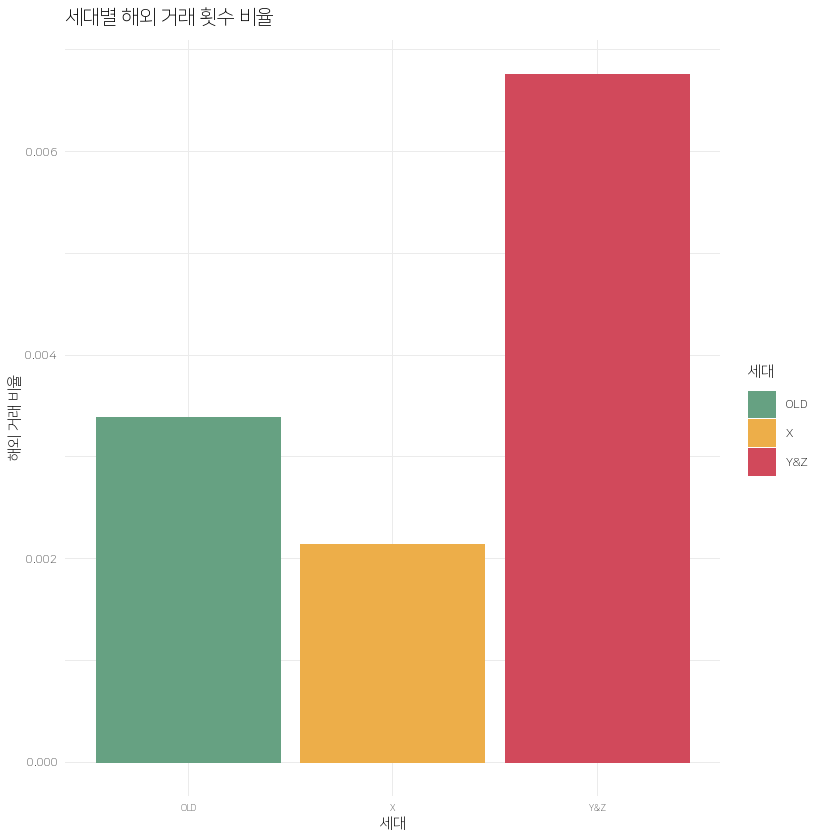

In [27]:
kr <- kr_dat %>% group_by(cus_id, gen, orr_dt) %>% summarise(kr = n()) # 고객별 국내 거래 횟수
oss <- oss_dat %>% group_by(cus_id, gen, orr_dt) %>% summarise(oss = n()) # 고객별 해외 거래 횟수
oss$orr_dt %<>% ymd()
total <- kr %>% left_join(oss, by = c('cus_id' = 'cus_id', 'gen' = 'gen', 'orr_dt' = 'orr_dt'))
total[is.na(total$oss),]$oss <- 0 # 해외 거래를 해본 적 없는 고객들의 oss는 0으로 대체

total %>% filter(gen != 'BABY') %>%  group_by(gen) %>% 
  summarise(kr = sum(kr), oss = sum(oss), ratio = sum(oss)/(sum(kr)+sum(oss))) %>% 
  ggplot(aes(x = gen, y = ratio)) +
  geom_bar(aes(fill = gen, color = gen), stat = 'identity') +
  labs(x = "세대", y = "해외 거래 비율", color = '세대', fill = '세대', title = "세대별 해외 거래 횟수 비율") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'),axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#66a182","#edae49","#d1495b")) +
  scale_fill_manual(values = c("#66a182","#edae49","#d1495b"))

- X세대와 OLD세대에 비해 Y&Z세대의 해외 거래 비율이 높습니다.

다음으로 해외 주식 거래를 한 번이라도 해본 적이 있는 고객의 비율을 세대별로 보았습니다.

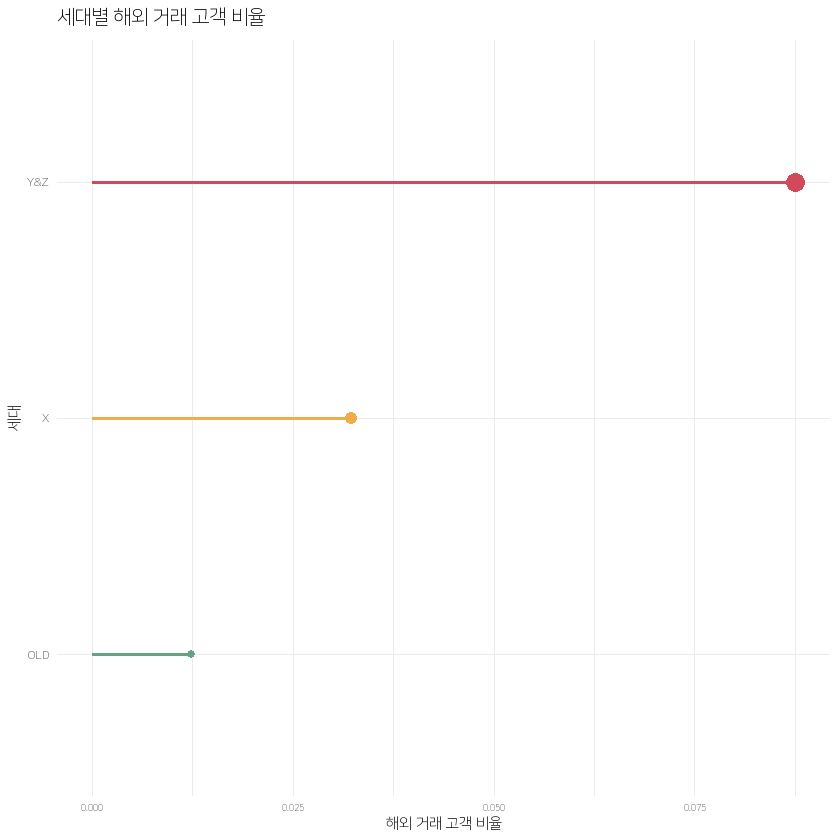

In [28]:
total %>% filter(gen != 'BABY') %>% group_by(cus_id, gen) %>% summarise(kr = sum(kr), oss = sum(oss)) %>% 
  mutate(oss_y = ifelse(oss >= 1, 1, 0), all = 1) %>%
  group_by(gen) %>% summarise(oss_y = sum(oss_y), ratio = oss_y/sum(all)) %>% 
  ggplot(aes(ratio, gen)) +
  geom_segment(aes(x = 0, y = gen, xend = ratio, yend = gen), color = c("#66a182","#edae49","#d1495b"), size = 1) +
  geom_point(color = c("#66a182","#edae49","#d1495b"), size = c(2,3,5)) +
  labs(x = "해외 거래 고객 비율", y = "세대", color = '세대', fill = '세대', title = "세대별 해외 거래 고객 비율") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(face='bold',family='square'))

- Y&Z세대가 모든 세대 중에서 해외 주식 거래를 경험해본 고객의 비율이 가장 큽니다.

평균적인 비율 외에도 시간의 흐름에 따른 '해외 거래 비율'의 변화를 보고자 시계열로 시각화하였습니다.

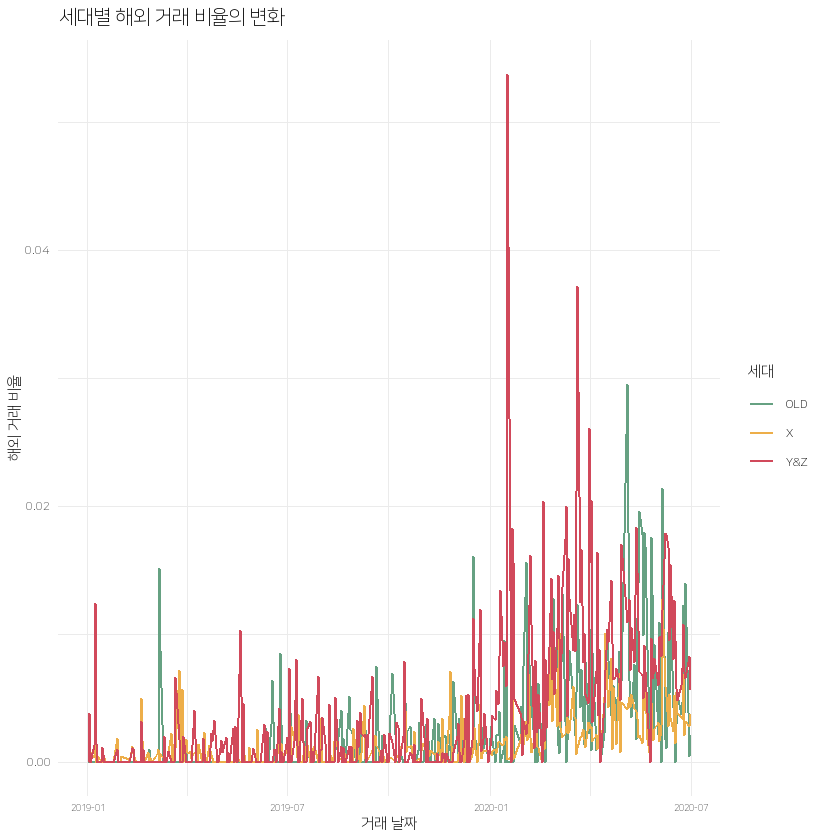

In [29]:
total %>% filter(gen != 'BABY') %>% 
  group_by(gen, orr_dt) %>% summarise(kr = sum(kr), oss = sum(oss), ratio = oss/(kr+oss)) %>%
  ggplot(aes(x = orr_dt, y = ratio)) +
  geom_line(aes(color = gen), size = 0.6) +
  labs(x = "거래 날짜", y = "해외 거래 비율", fill = "세대", color = "세대", title = "세대별 해외 거래 비율의 변화") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(face='bold',family='square')) +
  scale_color_manual(values = c("#66a182","#edae49","#d1495b"))

- 코로나 발생 이전, 즉 2020년 이전에는 모든 세대의 해외 거래 비율이 비슷했습니다.
- 그러나 코로나 이후로 Y&Z세대의 전체 주식 거래 중 해외 거래의 비중이 급격히 커졌습니다.

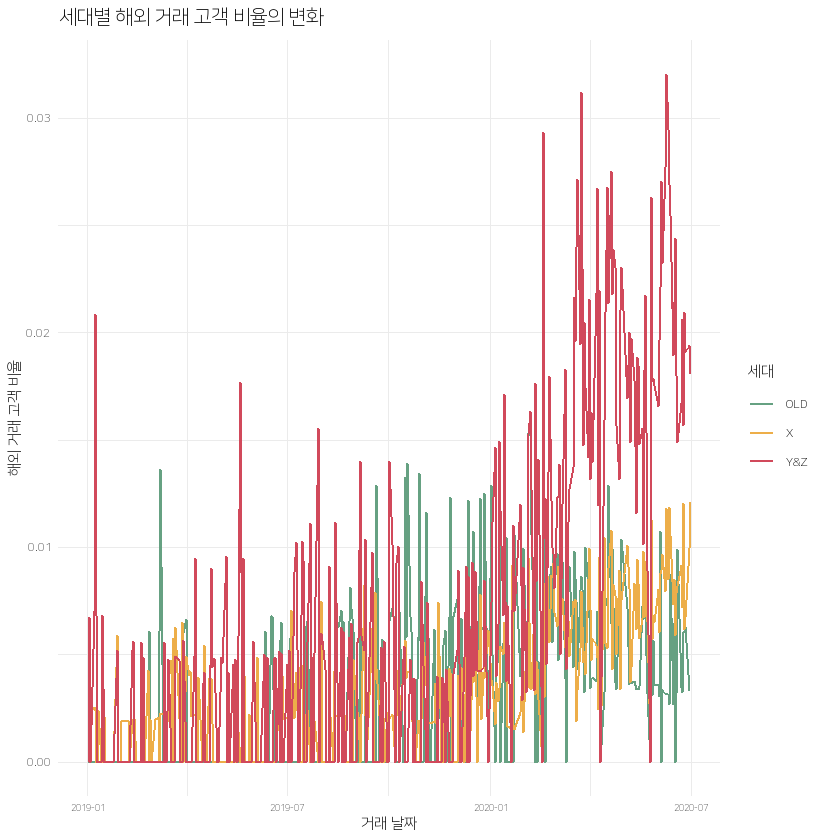

In [30]:
total %>% filter(gen != 'BABY') %>% group_by(cus_id, gen, orr_dt) %>% summarise(kr = sum(kr), oss = sum(oss)) %>%
  mutate(oss_y = ifelse(oss >= 1, 1, 0), all = 1) %>%
  group_by(gen,orr_dt) %>% summarise(oss_y = sum(oss_y), ratio = oss_y/sum(all)) %>% 
  ggplot(aes(x = orr_dt, y = ratio)) +
  geom_line(aes(color = gen), size = 0.6) +
  labs(x = "거래 날짜", y = "해외 거래 고객 비율", fill = "세대", color = "세대", title = "세대별 해외 거래 고객 비율의 변화") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(face='bold',family='square')) +
  scale_color_manual(values = c("#66a182","#edae49","#d1495b"))
        
rm(oss, kr, total)

- 해외 거래를 해본 고객의 비율의 추이를 보면, 거래 횟수에 비해 훨씬 더 다른 세대와 차이를 보입니다.
- 이를 통해 Y&Z세대 중 코로나 이후로 해외 거래를 시작한 고객들이 많아졌다고 유추할 수 있습니다.

위의 시각화들은 Y&Z세대가 다른 세대에 비해 해외 거래에 관심이 많다는 것을 보여줍니다.<br>
해외 주식 거래가 아무래도 국내 주식 거래에 비해 더 진입장벽이 높다는 것을 고려했을 때, Y&Z세대가 **다양한 주식 투자에 개방적**이라고 생각할 수 있습니다.

#### - 신생기업 주식 매매 관련 시각화

둘째로, 새로 상장한 기업에 대해 세대별로 얼마나 거래가 이루어지는지 알아보았습니다. <br><br>
먼저 '네이버 금융'에서 기업별 상장일자를 크롤링하였고, 상장일자를 찾을 수 없는 기업들을 제외한 후 **상장일자 기준 일주일 이내에 이루어진 거래의 비율**에 대해 시각화하였습니다.

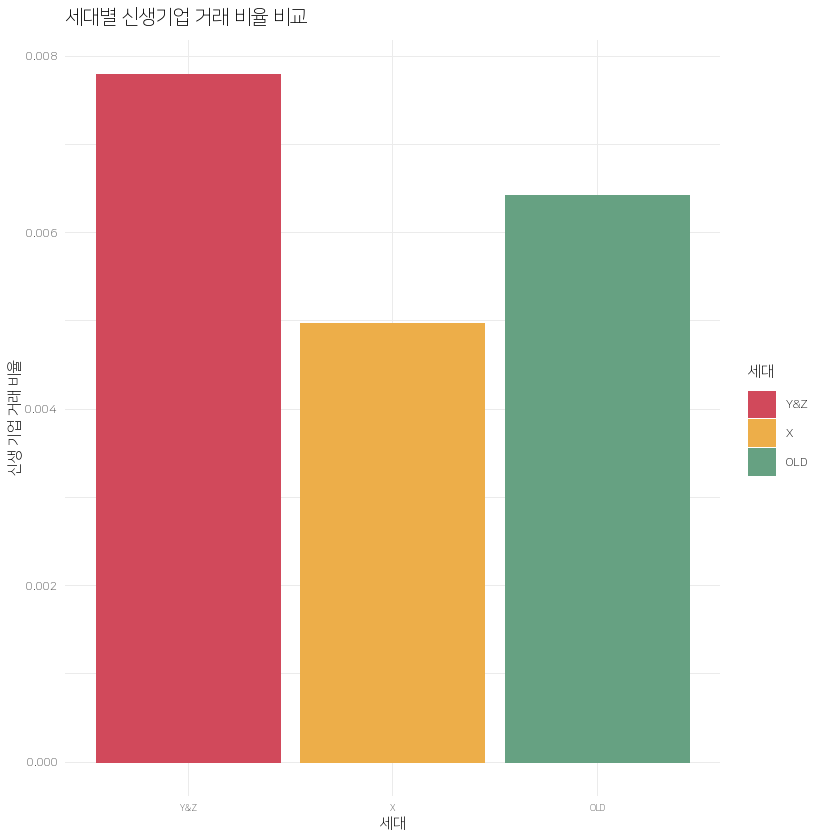

In [31]:
kr_dat %>% filter(gen != 'BABY') %>% mutate(dt_diff = orr_dt - listed_date) %>% filter(!is.na(.$dt_diff)) %>%
  mutate(new = ifelse(dt_diff <= 7 & dt_diff >= 0, 1, 0)) %>% 
  group_by(gen) %>% summarise(n = n(), new = sum(new)/n) %>% 
  ggplot(aes(x = gen, y = new)) +
  geom_bar(aes(fill = gen, color = gen), stat = 'identity') +
  labs(x = "세대", y = "신생 기업 거래 비율", fill = "세대", color = "세대", title = "세대별 신생기업 거래 비율 비교") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(face='bold',family='square')) +
  scale_color_manual(values = c("#d1495b","#edae49","#66a182")) +
  scale_fill_manual(values = c("#d1495b","#edae49","#66a182"))

- Y&Z세대가 전체 주식 거래 대비 새로 상장한 기업의 주식을 많이 거래하였습니다. <br><br>

다음으로 새로 상장한 기업에 대한 거래를 상장일 기준 당일/7일/30일/100일 이내로 범주화하여 세대별 거래 횟수의 비율을 보았습니다.

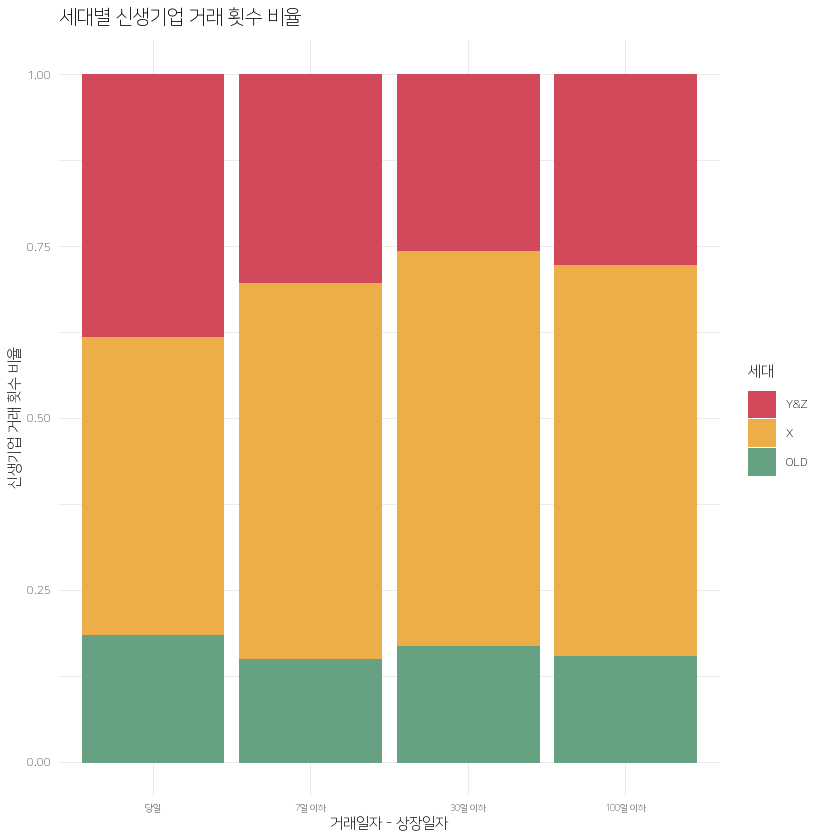

In [32]:
kr_dat %>% filter(gen != 'BABY') %>%  mutate(dt_diff = orr_dt - listed_date) %>% filter(dt_diff <= 100 & dt_diff >= 0) %>% 
  mutate(diff = ifelse(dt_diff == 0, '당일',
                       ifelse(dt_diff <= 7, '7일 이하',
                              ifelse(dt_diff <= 30, '30일 이하', '100일 이하')))) %>% 
  group_by(gen, diff) %>% tally() %>% 
  ggplot(aes(x = diff, y = n)) +
  scale_x_discrete(limits=c("당일", "7일 이하", "30일 이하","100일 이하")) +
  geom_bar(aes(fill = gen, color = gen), stat = 'identity', position = 'fill') +
  labs(x = "거래일자 - 상장일자", y = "신생기업 거래 횟수 비율", fill = "세대", color = "세대", title = "세대별 신생기업 거래 횟수 비율") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(face='bold',family='square')) +
  scale_color_manual(values = c("#d1495b","#edae49","#66a182")) +
  scale_fill_manual(values = c("#d1495b","#edae49","#66a182"))

- X세대의 고객 수가 훨씬 많다보니 X세대의 비율이 더 큽니다.
- 하지만 **기업이 상장한 당일에 거래한 건**에 대해서는 Y&Z세대가 X세대와 비슷한 정도의 비율을 차지하고 있습니다.
- 즉, Y&Z세대가 새롭게 상장한 기업의 주식을 당일에 많이 거래한다는 것을 알 수 있습니다.

시장에 새롭게 상장한 기업의 주식은 변동성이 클 수 밖에 없고, Y&Z세대가 다른 세대에 비해 이러한 주식을 많이 매매한다는 것은 결국 이들이 **변동성을 감수하는 경향이 있다**는 것을 의미합니다.

#### - ESG 등급 관련 시각화

마지막으로, 어떠한 세대가 주식의 수익률 뿐만 아니라 해당 기업의 비재무적 요소를 고려한 투자를 하는지 알아보기 위해 **기업의 ESG 등급과 관련된 시각화**를 진행했습니다. <br><br>
ESG 등급이란 E(Environment), S(Social Responsibility), G(Governance)의 약자로 기업의 사회적 가치를 측정하는 요소입니다. 최근 **지속가능한 투자**라는 시각에서 ESG 관련 투자가 각광을 받고 있어, 세대별로 얼마나 이러한 흐름에 맞추어 주식 투자를 하는지에 대해 알아보고자 했습니다.<br><br>
사용한 ESG 등급 데이터는 'KCGS 한국기업지배구조원'의 허가 하에 크롤링하여 사용했습니다.

먼저, 세대별로 각 ESG등급에 속한 기업들의 주식을 얼마나 거래했는지를 알아보기 위해 시각화를 진행했습니다.

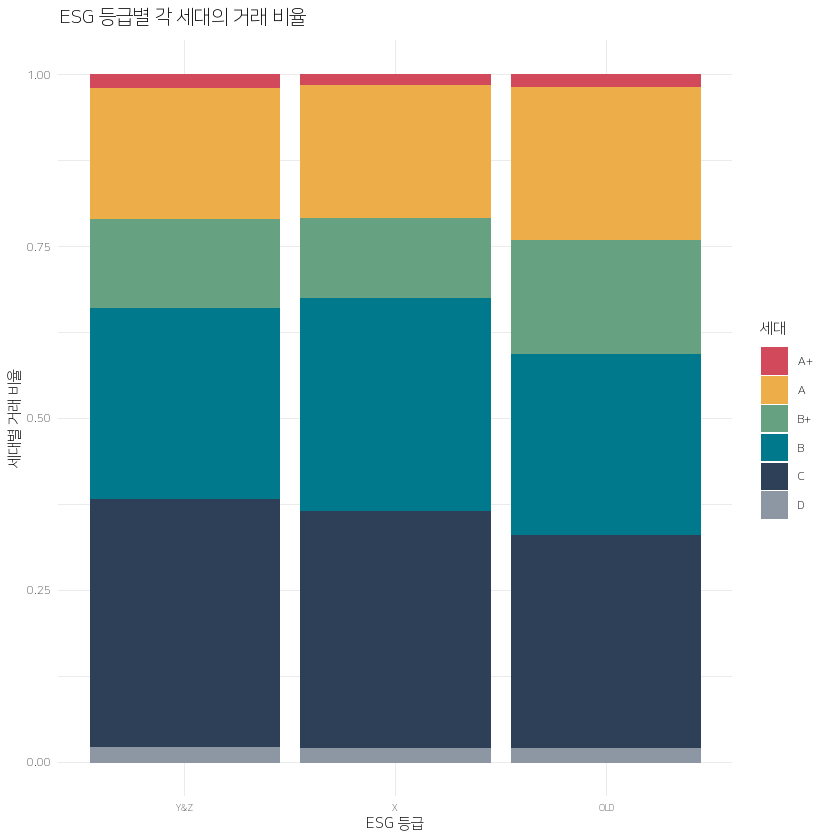

In [33]:
kr_dat %>% filter(gen != 'BABY', ESG != '미분류') %>% group_by(gen, ESG) %>% tally() %>% 
  ggplot(aes(x = gen, y = n)) +
  geom_bar(aes(fill = ESG, color = ESG), stat = 'identity', position = 'fill') +
  labs(x = "ESG 등급", y = "세대별 거래 비율", fill = "등급", color = "등급", title = "ESG 등급별 각 세대의 거래 비율") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(face='bold',family='square')) +
  scale_color_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3")) +
  scale_fill_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3"))

- 모든 세대 중에서 ESG 등급이 높은 기업(A+, A)들의 주식을 가장 많이 거래한 세대는 OLD세대입니다.
- Y&Z세대가 **ESG 등급이 낮은 기업(C,D)들의 주식을 가장 많이 거래**하였습니다.
- 이를 통해 Y&Z세대가 주식 거래를 하는 기업의 수익률 외적인 요소에 대한 고려가 부족하다는 것을 유추할 수 있습니다.

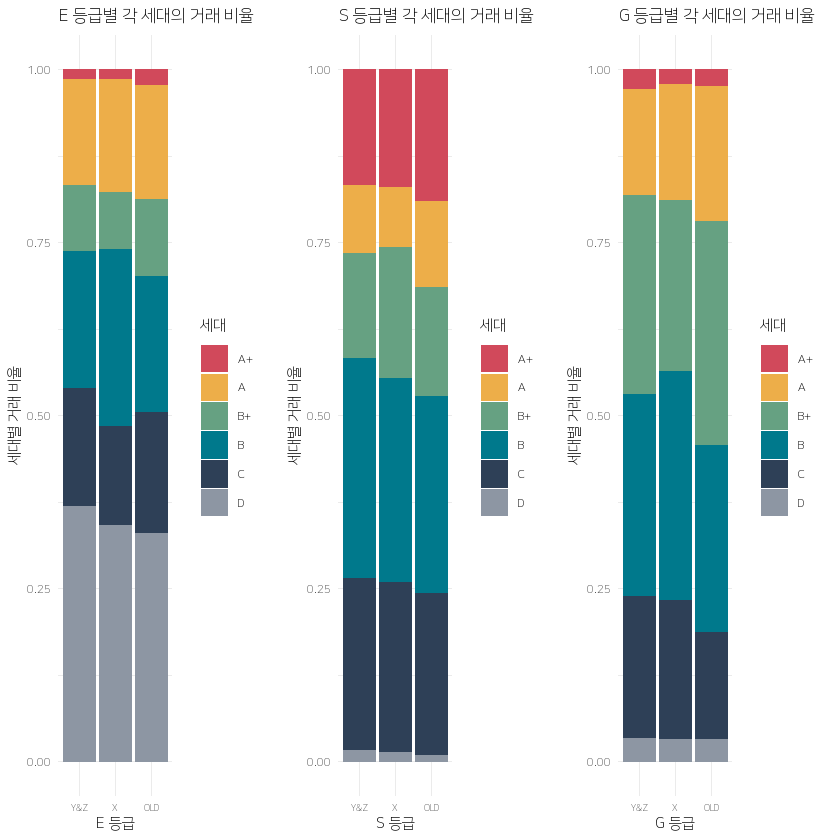

In [34]:
p1 <- kr_dat %>% filter(gen != 'BABY', E != '미분류') %>% group_by(gen, E) %>% tally() %>% 
        ggplot(aes(x = gen, y = n)) +
        geom_bar(aes(fill = E, color = E), stat = 'identity', position = 'fill') +
        labs(x = "E 등급", y = "세대별 거래 비율", fill = "세대", color = "세대", title = "E 등급별 각 세대의 거래 비율") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
        scale_color_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3"))
      
p2 <- kr_dat %>% filter(gen != 'BABY', S != '미분류') %>% group_by(gen, S) %>% tally() %>% 
        ggplot(aes(x = gen, y = n)) +
        geom_bar(aes(fill = S, color = S), stat = 'identity', position = 'fill') +
        labs(x = "S 등급", y = "세대별 거래 비율", fill = "세대", color = "세대", title = "S 등급별 각 세대의 거래 비율") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
        scale_color_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3"))
      
p3 <- kr_dat %>% filter(gen != 'BABY', G != '미분류') %>% group_by(gen, G) %>% tally() %>% 
        ggplot(aes(x = gen, y = n)) +
        geom_bar(aes(fill = G, color = G), stat = 'identity', position = 'fill') +
        labs(x = "G 등급", y = "세대별 거래 비율", fill = "등급", color = "등급", title = "G 등급별 각 세대의 거래 비율") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
        scale_color_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#d1495b","#edae49","#66a182","#00798c","#2e4057","#8d96a3"))

grid.arrange(p1, p2, p3, ncol = 3)

E,S,G 각 항목에 대한 등급을 기준으로 시각화를 해보아도<br>
- Y&Z세대는 등급이 높은 기업들에 대한 거래가 적고, 등급이 낮은 기업들에 대한 거래가 많은 모습을 보입니다.

이러한 Y&Z세대의 주식 거래 양상이 시간이 흐름에 따라, 그리고 주식 거래 유입이 많아짐에 따라 어떻게 변화해가고 있는지 보기 위해 시계열 그래프를 그려보았습니다.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



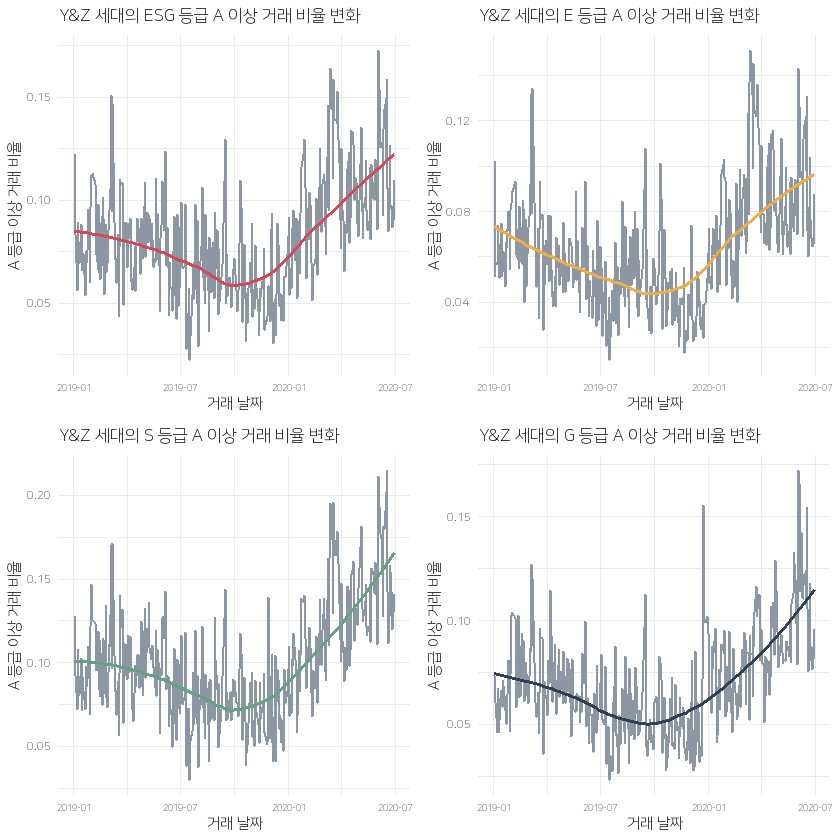

In [35]:
p1 <- kr_dat %>% filter(gen == 'Y&Z') %>% 
        mutate(rank = ifelse(ESG == 'A' | ESG == 'A+', 1, 0)) %>% 
        group_by(gen, orr_dt) %>% summarise(n = n(), A = sum(rank), ratio = A/n)  %>% 
        ggplot(aes(x = orr_dt, y = ratio), group = 1) +
        geom_line(aes(color = gen), color = "#8d96a3", size = 0.6) +
        stat_smooth(color = "#d1495b", method = "auto", se = F) +
        labs(x = "거래 날짜", y = "A 등급 이상 거래 비율", fill = "세대", color = "세대", title = "Y&Z 세대의 ESG 등급 A 이상 거래 비율 변화") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y=element_text(family='square',face='bold'))
      
p2 <- kr_dat %>% filter(gen == 'Y&Z') %>% 
        mutate(rank = ifelse(E == 'A' | E == 'A+', 'A','else'),
               A = ifelse(rank == 'A', 1, 0)) %>% 
        group_by(gen, orr_dt) %>% summarise(n = n(), A = sum(A), ratio = A/n)  %>% 
        ggplot(aes(x = orr_dt, y = ratio), group = 1) +
        geom_line(aes(color = gen), color = "#8d96a3", size = 0.6) +
        stat_smooth(color = "#edae49", method = "auto", se = F) +
        labs(x = "거래 날짜", y = "A 등급 이상 거래 비율", fill = "세대", color = "세대", title = "Y&Z 세대의 E 등급 A 이상 거래 비율 변화") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y=element_text(family='square',face='bold'))

p3 <- kr_dat %>% filter(gen == 'Y&Z') %>% 
        mutate(rank = ifelse(S == 'A' | S == 'A+', 'A','else'),
               A = ifelse(rank == 'A', 1, 0)) %>% 
        group_by(gen, orr_dt) %>% summarise(n = n(), A = sum(A), ratio = A/n)  %>% 
        ggplot(aes(x = orr_dt, y = ratio), group = 1) +
        geom_line(aes(color = gen), color = "#8d96a3", size = 0.6) +
        stat_smooth(color = "#66a182", method = "auto", se = F) +
        labs(x = "거래 날짜", y = "A 등급 이상 거래 비율", fill = "세대", color = "세대", title = "Y&Z 세대의 S 등급 A 이상 거래 비율 변화") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y=element_text(family='square',face='bold'))

p4 <- kr_dat %>% filter(gen == 'Y&Z') %>% 
        mutate(rank = ifelse(G == 'A' | G == 'A+', 'A','else'),
               A = ifelse(rank == 'A', 1, 0)) %>% 
        group_by(gen, orr_dt) %>% summarise(n = n(), A = sum(A), ratio = A/n)  %>% 
        ggplot(aes(x = orr_dt, y = ratio), group = 1) +
        geom_line(aes(color = gen), color = "#8d96a3", size = 0.6) +
        stat_smooth(color = "#2e4057", method = "auto", se = F) +
        labs(x = "거래 날짜", y = "A 등급 이상 거래 비율", fill = "세대", color = "세대", title = "Y&Z 세대의 G 등급 A 이상 거래 비율 변화") +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'),
              text = element_text(face = "bold",family='square'), axis.text.y=element_text(family='square',face='bold'))

grid.arrange(p1, p2, p3, p4, ncol = 2)

- 2020년 이전까지는 각 등급이 A 이상인 기업에 대한 거래 비율이 감소하는 추세였으나, 2020년 이후로 주식 매매가 활발해지고 새로운 고객이 많이 유입되면서 ESG 등급이 높은 기업들의 주식을 거래하는 비율이 증가하였습니다. <br><br>

Y&Z세대의 ESG등급이 높은 기업들에 대한 거래가 증가한 이유가 **장기적 투자에 대한 관심**인지 확인해보기 위해 각 등급별 주식의 보유 기간을 살펴보았습니다. 위의 본론 B에서 사용한 'period_dat' 데이터를 'ESG' 데이터와 합쳐 시각화를 진행했습니다.

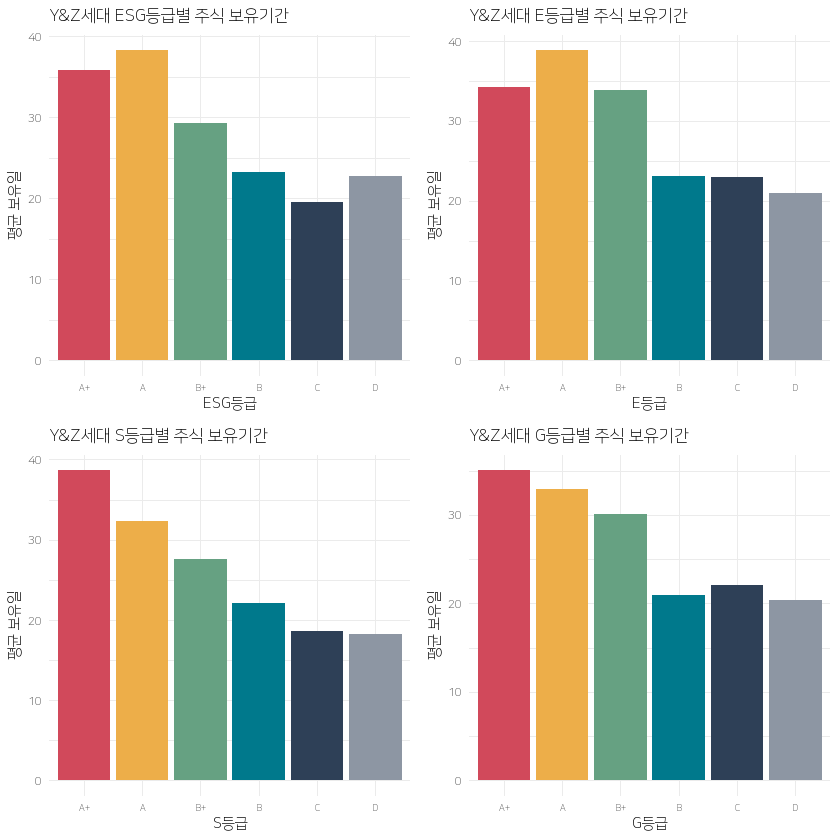

In [36]:
esg_boyu = left_join(period_dat, ESG, by=c('iem_cd'='iem_cd'))

p1 <- esg_boyu %>% filter(gen == "Y&Z" & ESG !="" & is.na(ESG) == F) %>% group_by(ESG) %>% 
        summarise(boyu = mean(period)) %>% 
        ggplot()+
        geom_bar(aes(x=ESG, y=boyu, fill=ESG), stat="identity")+
        labs(title="Y&Z세대 ESG등급별 주식 보유기간", x = 'ESG등급', y = '평균 보유일') +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'),
              legend.position = "none") +
        scale_color_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_x_discrete(limits = c("A+",'A','B+','B','C','D'))

p2 <- esg_boyu %>% filter(gen == "Y&Z" & E !="" & is.na(E) == F) %>% group_by(E) %>% 
        summarise(boyu = mean(period)) %>% 
        ggplot()+
        geom_bar(aes(x=E, y=boyu, fill=E), stat="identity")+
        labs(title="Y&Z세대 E등급별 주식 보유기간", x = 'E등급', y = '평균 보유일') +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'),
              legend.position = "none") +
        scale_color_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_x_discrete(limits = c("A+",'A','B+','B','C','D'))

p3 <- esg_boyu %>% filter(gen == "Y&Z" & S !="" & is.na(S) == F) %>% group_by(S) %>% 
        summarise(boyu = mean(period)) %>% 
        ggplot()+
        geom_bar(aes(x=S, y=boyu, fill=S), stat="identity")+
        labs(title="Y&Z세대 S등급별 주식 보유기간", x = 'S등급', y = '평균 보유일') +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'),
              legend.position = "none") +
        scale_color_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_x_discrete(limits = c("A+",'A','B+','B','C','D'))

p4 <- esg_boyu %>% filter(gen == "Y&Z" & G !="" & is.na(G) == F) %>% group_by(G) %>% 
        summarise(boyu = mean(period)) %>% 
        ggplot()+
        geom_bar(aes(x=G, y=boyu, fill=G), stat="identity")+
        labs(title="Y&Z세대 G등급별 주식 보유기간", x = 'G등급', y = '평균 보유일') +
        theme_minimal() +
        theme(plot.title = element_text(size = 13,family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
              text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'),
              legend.position = "none") +
        scale_color_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_fill_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
        scale_x_discrete(limits = c("A+",'A','B+','B','C','D'))

grid.arrange(p1,p2,p3,p4, ncol = 2)

rm(esg_boyu)

- 각 등급 기준마다 어느정도의 차이는 존재하지만, 전체적으로 보았을 때 **등급이 높을수록 그 주식의 평균적인 보유기간이 긴 것**을 확인할 수 있습니다. <br>
- 이를 통해 Y&Z세대가 ESG 등급이 높은 기업의 주식을 구매할 때, 장기적인 투자를 고려한다는 것을 유추할 수 있습니다.

지금까지 ESG 관련 시각화를 통해 얻은 인사이트를 종합해보면, Y&Z세대는 다른 세대와 비교했을 때 ESG등급을 고려한 투자의 비율이 크지 않지만 점점 그에 대한 관심이 커지고 있습니다. 또한 ESG등급이 높은 기업들의 주식을 오래 보유하고 있는 것으로 보아 **ESG등급을 통한 장기적 투자를 어느정도 의식하고 있다**는 것을 알 수 있었습니다.

결론적으로 저희는 Y&Z세대가<br><br>
**1) 해외 거래의 비중이 크다**는 것에서 이들이 활동하는 주식 시장의 범위가 넓다고 볼 수 있고,<br>
**2) 상장한지 얼마 안된 신생기업의 거래가 많다**는 것에서는 한국 주식 시장 내에서도 다양한 주식에 관심을 갖고 있다는 것을 알 수 있으며,<br>
**3) ESG 상위 등급 기업의 거래 비율이 점점 증가하는 추세**를 보인다는 점에서, 시장 외적인 측면에서의 요소들을 점점 고려해가고 있음을 유추할 수 있었습니다.<br><br>
종합적으로 주식 매매를 할 때 **"관심의 범위가 넓다"**는 것이 Y&Z세대의 특징이라고 정의하였습니다.

## 2. 모델링을 통한 변수 해석

이제 앞서 살펴본 Y&Z 세대의 특징을 활용해 파생 변수를 생성하고, 생성된 변수를 고객 데이터에 추가해 **세대**를 종속변수로 하는 **XGBoost 모델**을 만들어보려고 합니다.

고객성향, 고객등급, 주식종목 등 데이터에 존재했던 많은 변수 중에서도 **세대**를 종속변수로 하는 모델링을 한 이유는 **세대를 결정함에 있어서 어떤 변수가 결정적으로 작용하는지 보고자 했기 때문**입니다. 대회의 취지가 Y&Z세대 투자자를 프로파일링하는 것인만큼 다른 것보다도 세대 간 특성을 구분하는 것이 중요하다고 생각했습니다. 뿐만 아니라 주식 보유일, 회전율과 같이 저희가 만든 파생 변수들의 유의성을 확인하기 위한 의도도 있었습니다.

모델링이 끝난 뒤에는 XGBoost 모델에 대해 SHAP value를 계산함으로써 변수들의 영향력을 파악해보고자 합니다.SHAP value가 구체적으로 어떤 것이고, 어떻게 계산되는지에 대해서는 추후 설명해드리도록 하겠습니다!

### A. XGBoost Modeling

#### 모델링을 위한 데이터 전처리

In [50]:
# 1. 개인 거래 중 수익증권형이 차지하는 비율
BEN_PROP<-kr_dat %>%
  mutate(ben=ifelse(category=='수익증권형',1,0),
  not_ben=ifelse(category!='수익증권형',1,0)) %>% 
  group_by(cus_id) %>% 
  summarise(ben_prop=sum(ben)/(sum(ben)+sum(not_ben)))

# 2. MTS 사용 비율
MTS_PROP<-kr_dat %>%
  mutate(mts=ifelse(orr_mdi_dit_cd=='MTS',1,0),
         not_mts=ifelse(orr_mdi_dit_cd!='MTS',1,0)) %>% 
  group_by(cus_id) %>% 
  summarise(mts_prop=sum(mts)/(sum(mts)+sum(not_mts)))

# 3. 해외 거래 비율
cus_info2<-cus_info %>% 
  select(cus_id,gen)

oss_dat2<-oss_dat %>% 
  group_by(cus_id) %>% 
  summarise(oss_n=n())

OSS_PROP<-kr_dat %>% 
  group_by(cus_id) %>% 
  summarise(kr_n=n()) %>% 
  left_join(oss_dat2,by='cus_id') %>% 
  left_join(cus_info2,by='cus_id') %>% 
  mutate(oss_n=ifelse(is.na(oss_n),0,oss_n)) %>% 
  mutate(oss_prop=oss_n/(kr_n+oss_n)) %>% 
  select(cus_id,oss_prop)

rm(cus_info2, oss_dat2)

# 4. 주식 보유일 평균값
period<-DATA2
period<-period %>% 
  filter(period!='stranger') %>% 
  mutate(period=as.numeric(period)) %>% 
  group_by(act_id) %>% 
  summarise(mean_period=mean(period))

actcus<-kr_dat %>% 
  group_by(act_id,cus_id) %>% 
  summarise()

MEAN_PERIOD<-period %>% 
  left_join(actcus,by='act_id') %>% 
  group_by(cus_id) %>% 
  summarise(mean_period=mean(mean_period))

rm(actcus,period)

# 5. (하루 기준) 단타 횟수
dd = kr_dat %>% 
  group_by(cus_id, act_id, iem_krl_nm, orr_dt,
           sby_dit_cd, gen, category, big_cat,
           mid_cat) %>% 
  summarise()

dd$bs = ifelse(dd$sby_dit_cd=='매수', 1, -1)

danta = dd %>% 
  group_by(cus_id, act_id, iem_krl_nm, 
           orr_dt, gen, category, big_cat,
           mid_cat) %>% 
  summarise(oneday = sum(bs))

danta$dantayes = ifelse(danta$oneday==0, 1, 0)

DANTA_COUNT<-danta %>% 
  group_by(cus_id) %>% 
  summarise(danta_count = n())

rm(dd,danta)

# 6. 회전율 평균
turnover=final_dat
turnover<-turnover %>% drop_na() %>% filter(turnover!='stranger') %>% 
  mutate(turnover = as.numeric(turnover)) %>%
  group_by(cus_id) %>% 
  summarise(mean=mean(turnover,na.rm = TRUE))

# 7. ESG 상위 등급 거래 비율
ESG_PROP<-kr_dat %>% 
    mutate(YESG=ifelse(ESG=='A'|ESG=='A+',1,0),
           NESG=ifelse(ESG=='A'|ESG=='A+',0,1)) %>% 
    group_by(cus_id) %>% 
    summarise(ESG_prop=sum(YESG)/(sum(YESG)+sum(NESG)))

In [51]:
data = turnover

data<-data %>% 
  left_join(BEN_PROP,by='cus_id') %>% 
  left_join(MTS_PROP,by='cus_id') %>% 
  left_join(OSS_PROP,by='cus_id') %>% 
  left_join(MEAN_PERIOD,by='cus_id') %>% 
  left_join(DANTA_COUNT,by='cus_id') %>% 
  left_join(ESG_PROP,by='cus_id') 

GEN = kr_dat %>% 
  group_by(cus_id,gen) %>% 
  summarise()

data<-data %>% 
  left_join(GEN,by='cus_id') %>% 
  mutate(gen=as.character(gen)) %>% 
  mutate(gen=ifelse(gen=='Y&Z','YZ',gen))

gen<-data$gen
data<-data %>% select(-cus_id,-gen)

In [52]:
write.csv(data,file='C:/Users/seses/Desktop/대학/공모전/NH투자증권/최종 데이터/FORXGBOOOOOOST_X.csv',row.names=F)
write.csv(gen,file='C:/Users/seses/Desktop/대학/공모전/NH투자증권/최종 데이터/FORXGBOOOOOOST_Y.csv',row.names=F)

In [53]:
rm(data, turnover, BEN_PROP, MTS_PROP, OSS_PROP, MEAN_PERIOD, DANTA_COUNT, ESG_PROP, GEN, gen)

#### 모델링(파이썬으로 진행)

In [4]:
## python ##
# 라이브러리 설치
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os

In [5]:
os.chdir("C:\\Users\\seses\\Desktop\\대학\\공모전\\NH투자증권\\최종 데이터")
X_features = pd.read_csv('FORXGBOOOOOOST_X.csv')
y_label = pd.read_csv('FORXGBOOOOOOST_Y.csv')

In [6]:
y_label=np.where(y_label['x']=='BABY',0,
                     np.where(y_label['x']=='YZ',1,
                             np.where(y_label['x']=='X',2,3)))

In [7]:
y_label=pd.DataFrame(y_label)

In [8]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, 
                                                    random_state=58)
print(X_train.shape, X_test.shape)

(3734, 7) (934, 7)


In [9]:
# Initial model 
xgb_model = XGBClassifier(n_estimators=100,
                          objective='multi:softprob',
                         num_class=4)

# paramter tuning
params = {
    'eta':[0.3,0.1,0.01],
    'max_depth':[3,5,7],
    'min_child_weight':[3,5,7],
    'colsample_bytree':[0.3,0.5,0.7],
    'random_state':[915]
}

gridcv = GridSearchCV(xgb_model, param_grid = params, cv=5)

gridcv.fit(X_train, y_train, early_stopping_rounds=30,
          eval_metric='merror', eval_set = [(X_test,y_test)],
          verbose=0)

print(gridcv.best_params_)

C:\Users\seses\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\seses\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'colsample_bytree': 0.5, 'eta': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'random_state': 915}


In [10]:
# best parameter로 모델 피팅
xgb_model = XGBClassifier(n_estimators=1000,
                          learning_rate=0.3,
                          max_depth=5,
                          min_child_weight=3, 
                          colsample_bytree=0.5,
                          objective='multi:softprob',
                          num_class=4,
                          random_state=915)

# 학습
mod=xgb_model.fit(X_train, y_train, eval_metric='merror',verbose=0)
y_pred = mod.predict(X_test)
y_proba = mod.predict_proba(X_test)

accuracy_score(y_test, y_pred) # 정확도

C:\Users\seses\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\seses\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


0.588865096359743

### B. SHAP value를 통한 모델 해석

해석에 앞서 먼저 SHAP value는 간단히 말해 각 변수가 관측치를 예측하는데 **얼마나 큰 기여를 하는지 알려주는 지표**라고 할 수 있습니다.

예를 들어, 집값이 예측하고자 하는 종속 변수이고 집의 면적, 층수, 공원 존재 여부, 고양이의 출입 가능여부라는 4개의 독립 변수인 모델이 있다고 해보겠습니다.
이때 집의 면적과 층수, 공원 존재 여부가 같은 값을 가지는 상태에서 고양이 출입이 가능한 경우 이 모델이 집값을 30억으로 예측하였고, 고양이 출입이 불가능한 경우에는 집값을 31억으로 예측하였다면 이 때 '고양이 출입 가능 여부'라는 변수의 기여도는 1억이라고 할 수 있습니다. 

이런 식으로 **기여도**의 개념을 활용한 것이 SHAP value입니다. SHAP value의 절댓값이 클수록 해당 변수는 예측에 큰 기여를 했다고 해석할 수 있습니다.

SHAP value가 갖는 장점이 있다면 Random forest, XGBoost와 같은 소위 '블랙박스' 모델에 대해서도 변수의 영향력에 대해 **정량적으로** 표현할 수 있다는 점입니다. 또한 SHAP 패키지를 활용하여 다양한 시각적 툴을 사용할 수 있다는 점도 SHAP의 강점입니다. 

이론적인 부분에 대해 더 궁금하신 분들은 아래의 링크를 참조해주시면 감사하겠습니다!
https://datanetworkanalysis.github.io/2019/12/23/shap1
https://evgenypogorelov.com/multiclass-xgb-shap.html#multiclass-xgb-shap

저희는 이 SHAP value를 이용하여 Y&Z세대로 예측된 obs 중 하나의 실제 변수 분포를 살펴보고, 이 obs가 Y&Z세대로 예측되는 것에 어떤 변수가 가장 큰 영향을 미쳤는지 살펴보려고 합니다. 더 나아가, 전체 test data에 대해 SHAP value를 살펴봄으로써 각 클래스에 대한 변수의 영향력을 보겠습니다.

In [11]:
# 라이브러리 설치
import shap

In [27]:
# obs 하나를 살펴보자
X_rand = X_test.sample(1,random_state=100)
idx = X_rand.index.values[0]
idx

2642

In [28]:
X_rand # 해당 obs의 독립변수 값(mean = 회전율)

,mean,ben_prop,mts_prop,oss_prop,mean_period,danta_count,ESG_prop
2642,98.195914,0.052245,1.0,0.0,5.465495,499,0.036735


In [29]:
y_label.iloc[idx:(idx+1)] # 해당 obs의 실제 세대 = 클래스 1 = YZ세대

,0
2642,1


In [30]:
y_pred[np.where(X_test.index.values==idx)[0]] # 해당 obs의 예측된 세대 값 = 클래스 1 = YZ

array([1])

#### SHAP Value 해석

In [31]:
explainer = shap.TreeExplainer(mod)
shap_values = explainer.shap_values(X_rand)
shap.initjs()
for which_class in range(0,4):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))

<img src = "https://user-images.githubusercontent.com/52098204/103389433-254ae980-4b52-11eb-9635-54fafe75b251.png" width = 1000 align = "center">

먼저 위 네 개의 그래프는 해당 obs에 대한 각 클래스의 그래프를 나타냅니다. 저희 데이터의 Y값은 BABY, Y&Z, X, OLD의 4개의 클래스를 가졌으니까, 각 클래스 1개씩 총 4개의 그래프를 그려봤습니다.

그래프에 나와있는 수치와 색상의 뜻 그리고 f(x)와 base value의 의미에 대해 설명드리겠습니다.
먼저 base value는 i개의 클래스가 있는 범주형 데이터일 경우 i개의 유니크한 값을 갖는데요, 그 이유는 학습한 모델에서 i번째 클래스로 예측된obs들의 logodds값에서 그 obs들의 i번째 클래스에 대한 SHAP value의 합을 뺀 것의 평균이기 때문입니다. 

In [32]:
logodds = mod.predict(X_train, output_margin=True) # 모델을 통해 예측된 logdodds값(output_margin=True를 통해 예측확률이 아닌 logodds값을 반환)

explainer = shap.TreeExplainer(mod) 
shap_values = explainer.shap_values(X_train) # train 데이터의 shap values

# base value는 이런식으로 생겼습니다
explainer.expected_value # expected_value = base value 입니다

[-1.8885515, 1.3434871, 1.303323, -1.1331797]

In [33]:
# shap value는 이런식으로 생겼습니다(4개(클래스 개수)의 array로 구성, 각 array는 3206개(train set의 nrow)의 리스트로 구성, 각 리스트는 7개(변수의 개수)의 값으로 구성)
shap_values

[array([[-1.1644038 , -0.00395139, -0.20901972, ..., -2.3281255 ,
          0.2196792 , -0.5572688 ],
        [-1.8948333 , -0.03284476, -0.24977212, ..., -1.9935255 ,
         -0.46445343, -1.0692943 ],
        [-1.3584051 , -0.00533533, -0.24436209, ...,  0.85561836,
         -0.14567545, -1.7837005 ],
        ...,
        [-1.5570391 , -0.21521905, -0.25587356, ..., -3.36963   ,
         -1.6009048 ,  0.11338795],
        [-0.85183245,  0.0244338 , -0.31914973, ..., -1.8809656 ,
         -0.7366327 , -0.9811193 ],
        [-0.37170914, -0.23194599, -0.17544906, ..., -2.2910209 ,
         -2.6325815 , -0.22526601]], dtype=float32),
 array([[-0.48180455, -0.33746946,  0.08802427, ..., -0.88228536,
          0.16389486, -0.22014895],
        [ 1.2368944 , -0.15743196,  0.09547393, ..., -0.14729555,
         -0.12017956,  0.10854174],
        [-0.9297035 , -0.34801397,  0.11232658, ...,  0.49009192,
          0.07572842, -0.25347313],
        ...,
        [-0.03524837,  0.16871902,  0.7

In [34]:
explainer = shap.TreeExplainer(mod)
shap_values = explainer.shap_values(X_rand)
shap.initjs()
for which_class in range(0,4):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))

*(업로드 시 SHAP 그래프가 뜨지 않는 것을 확인하여 캡쳐한 사진으로 대체합니다.)*

<img src = "https://user-images.githubusercontent.com/52098204/103389433-254ae980-4b52-11eb-9635-54fafe75b251.png" width = 1000 align = "center">

각 그래프마다 진하게 표시된 **-8.21, 4.98, -0.41, -5.14**가 해당 obs의 각 클래스에 대한 shap value와 base value의 합, 간단히 말해 **'predicted value'** 이고, 이 값이 제일 큰 클래스가 obs의 예측 클래스가 됩니다.

앞서 저희는 Y&Z세대로 예측된 obs를 불러왔고, 위 그래프를 봤을 때 2번째 클래스, 즉 클래스 1의 predicted value가 4.98로 가장 큰 값이므로 해당 obs는 클래스1인 Y&Z로 예측이 되는 것입니다.

분홍색과 파란색의 색은 변수가 해당 obs가 예측되는 것에 **양** 의 영향을 갖는지, **음** 의 영향을 갖는지를 구분해주는 지표입니다.

이 색은 클래스마다 다른 값을 갖는데요, 클래스마다 변수가 끼치는 영향력이 다르게 작용하기 때문입니다. 영향력의 크기를 숫자로 나타낸다면 방향에 상관없이 **그 수가 클수록 해당 변수는 Y값에 큰 영향**을 주는 변수라는 의미입니다.

다시 본 데이터로 돌아가, 저희가 초점을 맞춰야하는 클래스 1의 그래프에 대해 보겠습니다. 

<img src = "https://user-images.githubusercontent.com/52098204/103389434-267c1680-4b52-11eb-90f4-5eade0b5a121.png" width = 800 align = "center">

In [35]:
obs_shapvalue=pd.DataFrame(shap_values[1][0]).transpose()
obs_shapvalue.columns = X_test.columns
obs_shapvalue

,mean,ben_prop,mts_prop,oss_prop,mean_period,danta_count,ESG_prop
0,0.645082,0.063196,0.063907,-0.052594,1.132009,0.630718,1.150748


클래스 1의 그래프에 위의 설명을 조금 더 직관적으로 볼 수 있도록 덧붙여본 것이 위의 사진이고, 위의 표는 이 obs의 각 컬럼(변수)별 shap value입니다.

해당 obs의 경우 클래스 1에 대해 danta_count, 즉 **ESG 상위 기업 거래 비율**이 양의 영향력을 미쳤습니다. 구체적인 수치는 1.150748로 방향에 상관없이 이 obs가 클래스1로 예측되도록 하는 것에 가장 큰 영향을 미친 변수였습니다. 따라서 ESG 상위 기업 거래 비율이 0.03673인 것이 obs가 Y&Z세대로 예측되는 것에 양의 영향력을 미쳤다고 할 수 있습니다. 

그 다음으로는 mean_period, 즉 **평균 주식 보유일**의 shap value가 로 양의 방향으로 큰 영향력을 미친 것으로 파악됐습니다. 이 obs의 경우 평균적으로 5.465일이라는 짧은 기간 주식을 보유한 것이 Y&Z세대로 예측되는 데 양의 영향력을 미쳤다고 해석할 수 있습니다. 

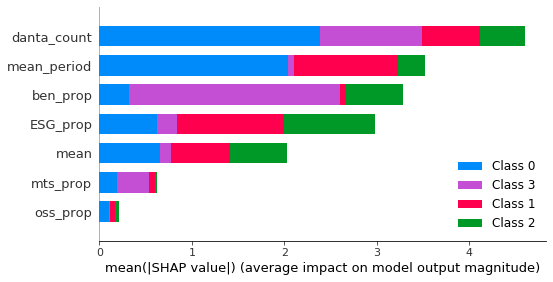

In [36]:
shap.summary_plot(shap_values, X_test)

위의 summary plot은 클래스1 뿐만 아니라 다른 클래스들의 shap value들도 포함하여 **어떤 변수**가 **어떤 클래스**에 **얼마만큼의 영향력**을 미쳤는지를 보여줍니다. 

예를 들어 이 obs는 클래스3의 범주일 경우 수익증권형 거래 비율이 가장 큰 영향을, 그 다음으로는 단타 거래 횟수가 큰 영향을 미칩니다. 

종합하여 보았을 때 이 obs의 세대를 구분짓는 것에 가장 큰 영향을 미치는 것은 SHAP value에 절댓값을 씌웠을 때의 평균 합이 제일 큰 단타 거래 횟수였고, 그 다음을 평균 보유일, 수익증권형 거래 비율, ESG 구매 비율, 회전율이 뒤따랐습니다.

이를 통해 저희 **Team 놀면뭐하니**가 **직접 만든 변수**였던 ben_prop(크롤링을 통해 만든 종목 변수 중 '수익증권형' 값을 활용한 파생변수)과 mean_period(평균보유일, 보유일에 대한 정의를 내린 후 변수 생성), dantan_count(단타에 대한 정의 내린 후 변수 생성), mean(회전율에 대한 공식을 활용해 직접 계산해 변수 생성), ESG_prop(ESG 상위 그룹 추출해 비율로 변수 생성)이 **전체 변수 중 영향력(기여도)가 가장 높은 변수 5개인 것을 확인**할 수 있습니다. 

# 3. 결론

저희가 본론에서 시각화를 통해 정의한 Y&Z세대의 특징을 다시 한 번 정리하고 가자면, <br><br>
&nbsp; __1) 간편한 주식 거래를 추구하고,__ <br>
&nbsp; __2) 단기적인 수익성에 집중하며,__ <br>
&nbsp; __3) 관심의 범위가 넓다__
&nbsp;는 것입니다. <br><br>

결론에서는 이러한 특징을 통해 이루어지는 Y&Z세대의 수익률을 평가하고, 그에 맞는 신규 상품 및 서비스를 제안하도록 하겠습니다.

## 1. 수익률 평가

수익률은( $\frac{매도시 기준가-매수시 기준가}{매수시 기준가}$ )$*$ $100%$ 로 계산됩니다. 이는 매도하였을 시에는 수익률이 되고, 매도하지 않았을때는 매수 기준가격에 비해 얼마나 변화했는지 증감률이 됩니다. 하지만 주어진 데이터를 이용해 매 거래마다의 수익률을 정확히 계산할 수는 없기에 일주일 간격의 시점별로 계좌, 상품별 수익률을 다음 식을 이용해 구했습니다. <br>
### ( $\frac{매도 기준가 * 매도 수량 + 해당 시점의 주가 * 남은 주식의 수량 - 매수 기준가 * 매수 수량}{매수 기준가 * 매수 수량}$ )$*$ $100%$

이를 통해 해당 시점 전까지 매도를통한 수익과 시세 이익을 계산할 수 있습니다. 

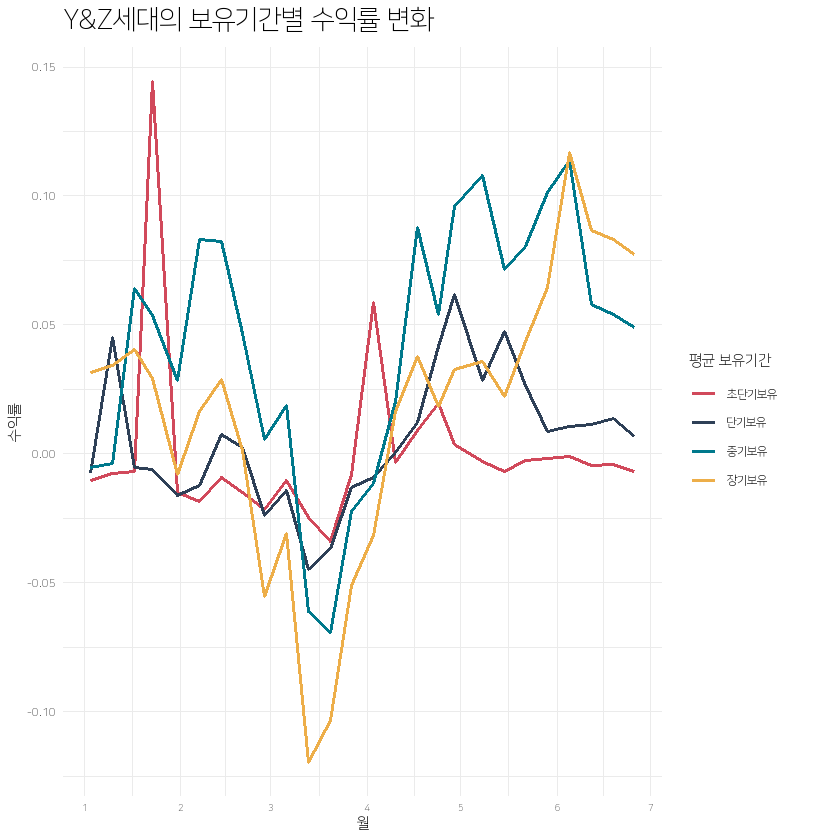

In [54]:
files = setdiff(list.files(), "KOSPI.csv")
stock_days = fread(files[1]) %>% select(Date) %>% unlist(use.names = F)
date_list = seq(as.Date("2019-01-04"), as.Date("2020-06-26"), by='7 days')
date_list[!date_list %in% stock_days]=c("2019-02-28", "2019-09-11", "2020-01-23","2020-04-29")
# 매주 금요일을 기준으로 수익률을 계산하였고, 공휴일의 경우 해당 주의 가장 인접한 날로 대체하였습니다. 
# 상품별로 해당 날짜의 종가 가져오기
close_dat = NULL
for(i in 1:length(files)){
  data = fread(files[i])
  tmp = data[data$Date%in%date_list,] %>% mutate(iem_cd = substr(files[i],1,7))
  close_dat = rbind(close_dat, tmp)
}
dat = kr_dat %>% filter(act_opn_ym >'2019-01-01') 
id_list = unique(dat$act_id)
stranger = c()
for (i in 1:length(id_list)){
  id = id_list[i]
  id_dat = dat %>% filter(act_id==id) %>% arrange(orr_dt)
  if (id_dat[1, 'sby_dit_cd']=="매도"){
    stranger = c(stranger, id)
  }
}

dat %<>% filter(!(act_id%in%stranger)) %>% 
  mutate(total_pr = orr_pr * cns_qty,
         buy_qnt = ifelse(sby_dit_cd=="매수", cns_qty, 0),
         sell_qnt = ifelse(sby_dit_cd=="매도", cns_qty, 0 ),
         buy = ifelse(sby_dit_cd=="매수", total_pr, 0),
         sell = ifelse(sby_dit_cd=="매도",total_pr, 0))

profit_data = NULL
for(i in 1:length(date_list)){
  final_data = dat %>% filter(orr_dt<=date_list[i]) %>% 
    group_by(act_id, iem_krl_nm, iem_cd, gen, cus_id) %>% 
    summarise(tot_sell = sum(sell), tot_buy = sum(buy),buy_qnt= sum(buy_qnt), sell_qnt = sum(sell_qnt)) %>% 
    ungroup()
  final_data$left_qnt = final_data$buy_qnt-final_data$sell_qnt
  final_data = final_data %>% filter(left_qnt >=0)
  final = left_join(final_data, close_dat[close_dat$Date==date_list[i], c('Close', 'iem_cd')], by='iem_cd')
  final$profit = (final$tot_sell + final$Close*final$left_qnt-final$tot_buy)/final$tot_buy
  final$time = date_list[i]
  profit_data = rbind(profit_data, final)
  
}
final_profit =profit_data %>% drop_na() %>% group_by(cus_id, time) %>% 
  summarise(profit = mean(profit))

period = period_dat  %>% filter(act_opn_ym>"2019-01-01") %>%
  group_by(cus_id, gen) %>%
  summarise(mean_period = mean(period, na.rm=T)) %>% drop_na() %>% ungroup()%>% 
  mutate(period_q = factor(ifelse(mean_period<2, 0, quantcut(mean_period, q=c(0, 0.25, 0.75,1))),labels=c("초단기보유", "단기보유", "중기보유", "장기보유")))

## 2일 이하로 보유한 고객은 초단기보유, 제 1사분위수 이하 보유 고객은 단기보유, 제 1사분위수에서 제 3사분위수 사이 고객은 중기보유로, 그 외는 장기보유로 범주화 하였습니다. 
profit_final = left_join(final_profit, period, by='cus_id')
profit_final %>%filter(gen=="Y&Z" & time>="2020-01-01") %>%
  group_by(time, period_q) %>% 
  summarise(mean_pf = mean(profit, na.rm=T)) %>% 
  ggplot(aes(x=time, y=mean_pf))+
  geom_line(aes(color=factor(period_q), group=factor(period_q)), size=1)+
  labs(title="Y&Z세대의 보유기간별 수익률 변화", color="평균 보유기간", x="월", y="수익률")+
  theme_minimal()+
  theme(plot.title = element_text(size = 20,family='square'),axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#d1495b","#2e4057","#00798c","#edae49")) +
  scale_fill_manual(values = c("#d1495b","#2e4057","#00798c","#edae49"))+
  scale_x_date(date_labels = "%b", date_breaks = 'months')

평균 보유기간으로 고객을 범주화하여 Y&Z세대의 2020년의 수익률 변화를 살펴보았습니다. 
- 초단기보유 고객의 경우 시장의 변동성과 무관하게 0 주변을 웃도는 값을 가집니다. 따라서 코스피가 폭락하는 2월부터 3월 중순에 감소하는 폭이 가장 적지만, 시간이 지나 시장의 변동성이 회복되어도 다른 고객에 비해 수익률을 올리지 못합니다. 
- 장기 보유 고객의 경우 코스피가 폭락하는 시기에 수익률도 동시에 폭락하지만, 시장이 안정화되면서 빠르게 수익률을 회복하고, 6월 이후에는 가장 높은 수익률을 보였습니다. 
- 코스피 급락 시기를 제외하면 중, 장기 보유 고객의 수익률이 가장 높은 수준을 유지합니다. 

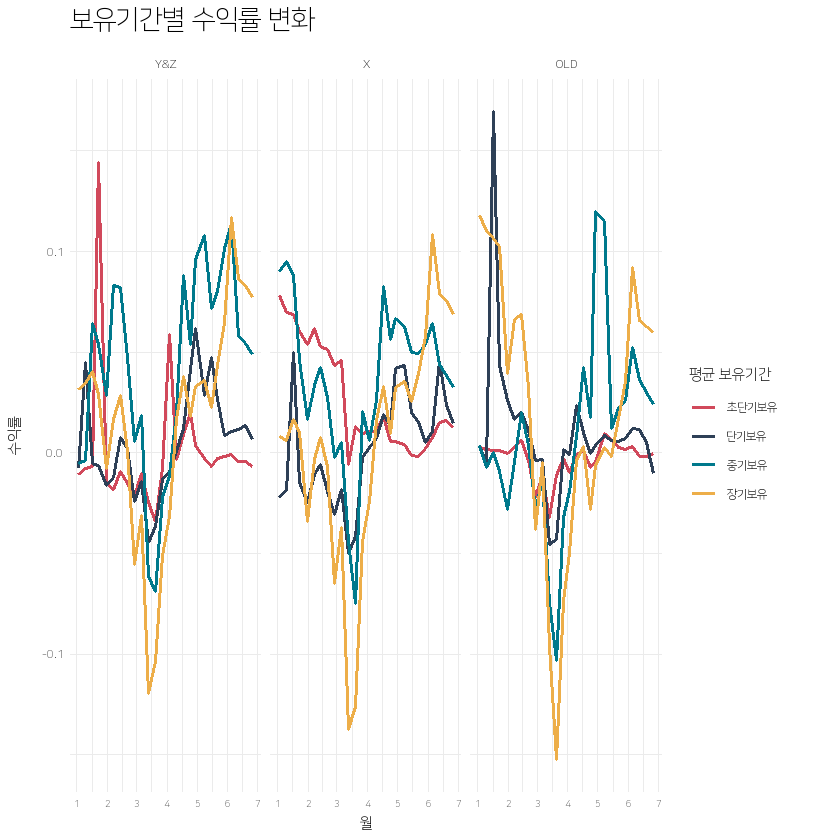

In [55]:
profit_final %>% filter(time>="2020-01-01"& gen!="BABY") %>%
  group_by(gen, time, period_q) %>% 
  summarise(mean_pf = mean(profit, na.rm=T)) %>% 
  ggplot(aes(x=time, y=mean_pf))+
  geom_line(aes(color=factor(period_q), group=factor(period_q)), size=1)+
  labs(title="보유기간별 수익률 변화", color="평균 보유기간", x="월", y="수익률")+
  theme_minimal()+
  theme(plot.title = element_text(size = 20,family='square'),axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#d1495b","#2e4057","#00798c","#edae49")) +
  scale_fill_manual(values = c("#d1495b","#2e4057","#00798c","#edae49"))+
  scale_x_date(date_labels = "%b", date_breaks = 'months')+
  facet_grid(~gen)

모든 세대에 대하여 수익률 변화를 살펴보았습니다.
- 다른 세대에서도 마찬가지로 시장의 변동에는 장기보유 고객의 수익률이 가장 큰 영향을 받지만, 시장이 안정화 되면서 장기 보유 고객이 가장 높은 수익률을 보입니다. 
- 시간이 흐를수록 Y&Z세대에서 장기보유 고객과 초단기보유 고객의 수익률 격차가 더욱 커집니다. 

Y&Z의 투자 비중이 가장 높았던 수익증권형에서 보유기간별로 수익이 어떻게 변화하는지도 살펴보았습니다. 

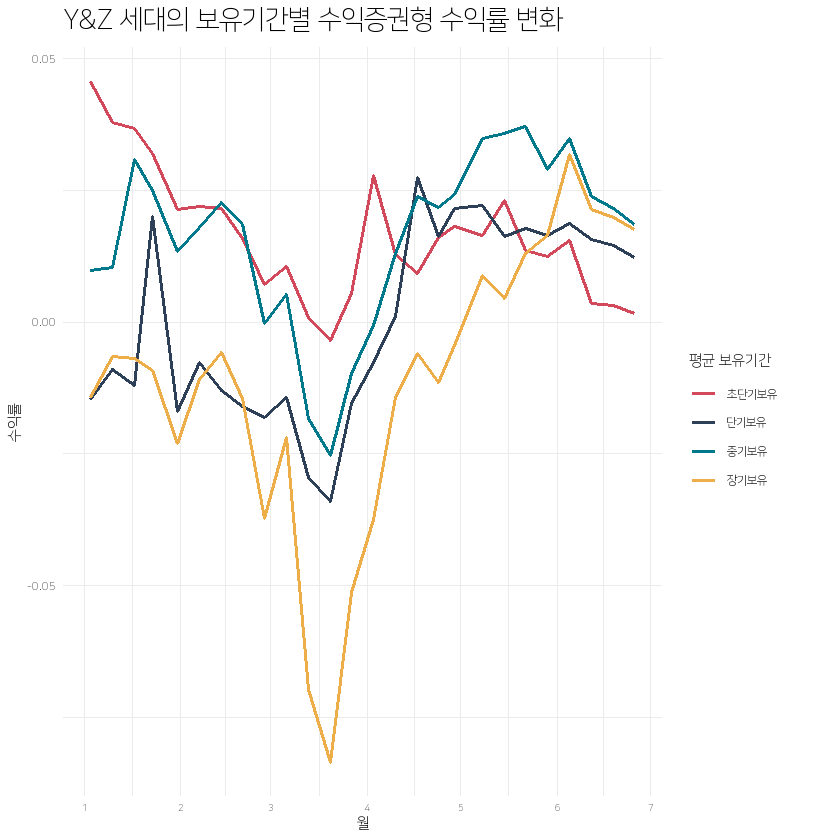

In [56]:
et_list = kr_dat$iem_krl_nm[kr_dat$category=="수익증권형"] %>% unique()
summary_dat = kr_dat %>% summarise(act_id, cus_id, iem_cd, iem_krl_nm, gen, act_opn_ym)
sooik_profit = left_join(summary_dat, DATA2, by=c('act_id', 'iem_cd'))
sooik_boyu =sooik_profit %>% 
  filter(gen!="BABY"& act_opn_ym>"2019-01-01"&iem_krl_nm%in%et_list) %>% 
  group_by(cus_id) %>% 
  summarise(mean_period = mean(period)) %>% 
  mutate(period_q = factor(ifelse(mean_period<1, 0, quantcut(mean_period, q=c(0, 0.25, 0.75,1))),labels=c("초단기보유", "단기보유", "중기보유", "장기보유"))) 
# 수익증권형 보유일의 분포가 작은값에 치우쳐져 있기에 초단기 보유의 기준을 1로 잡았습니다. 

sooik_final = left_join(profit_data, sooik_boyu, by='cus_id')
sooik_final %>% filter( gen=="Y&Z"&(time>"2020-01-01"))%>%
  drop_na() %>% 
  group_by(gen, time, period_q) %>% 
  summarise(mean_profit =mean(profit, na.rm=T)) %>% 
  ggplot()+
  geom_line(aes(x=time, y=mean_profit, color=factor(period_q), group=factor(period_q)), size=1)+
  labs(title="Y&Z 세대의 보유기간별 수익증권형 수익률 변화", color="평균 보유기간", x="월", y="수익률")+
   theme_minimal()+
  theme(plot.title = element_text(size = 20,family='square'),axis.text.x = element_text(size=7,family='square',face='bold'),
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold')) +
  scale_color_manual(values = c("#d1495b","#2e4057","#00798c","#edae49")) +
  scale_fill_manual(values = c("#d1495b","#2e4057","#00798c","#edae49"))+
  scale_x_date(date_labels = "%b", date_breaks = 'months')

- 초단기 보유 고객의 수익률은 시기 불문 0에 가까운 플러스 수익률을 보입니다.
- 중, 장기 보유 고객의 수익률은 초반에 마이너스 수익률을 보이다 코스피 급락과 함께 급락하지만, 시장이 안정화 되면서 빠른속도로 증가하여 6월부터는 가장 높은 수익률을 보입니다.
- 이는 안정화된 상황에서 장기보유고객이 장기적으로 초단기, 단기 보유 고객보다 높은 수익률을 가질 가능성을 시사합니다. 
- 최소 예금 금리 이상의 수익률을 투자를 통해 얻고자 한다면 장기 보유 후 안정적 시기를 기다리는 선택이 바람직하다고 말할  수 있습니다. 

보유 기간으로 고객을 분류하여 본 수익률 변화 시각화를 통해 우리는 초단기, 단기 보유보다 **장기 보유의 선택이 일정 수준의 수익률 확보의 기회를 준다**고 결론내릴 수 있었습니다. 즉, Y&Z세대의 많은 비중이 보였던 단기적 이익 추구 성향은 오히려 어느 정도의 수익도 보장하지 못하는 결과로 이어졌다고 볼 수 있습니다. 따라서 Y&Z 세대가 수익률을 올리기 위해서는 장기적인 투자의 방향으로 나아가야 할 필요성을 가집니다. <br><br>

#### 그렇다면 어떻게 단기적 이익 추구 성향의 Y&Z 세대를 장기적인 길로 이끌 수 있을까요? 

## 2. 신규 상품 및 서비스 제안

지금까지 Y&Z세대의 수익률 평가를 통해 Y&Z세대의 단타 위주 투자가 수익률을 보장하지 않는다는 것을 보여드렸습니다. <br>
저희는 이러한 점을 보완하고자 **Y&Z세대의 흥미를 끌 수 있으면서 장기 투자가 가능한 상품**이 필요하다고 판단했습니다. <br>
이를 만족시킬 수 있는 상품으로 생각한 것은 바로, **"ESG ETF/ETN"** 입니다.

### 왜 "ESG ETF/ETN" 인가요?

#### 1) Y&Z세대의 특징 반영

ETF와 ETN은 각각 최소 10개/5개 이상의 종목들로 구성되어 있어야 하기 때문에 다양한 종목에 관심을 갖는 Y&Z세대에게 **여러 종목을 한 번에 구매하는 효과를 누릴 수 있다**는 점이 장점으로 다가올 것이라고 생각합니다. <br><br>

또한, Y&Z세대는 **'가치 소비'를 하는 세대**로 알려져있습니다. 

<img src = "https://user-images.githubusercontent.com/52098204/103389435-2714ad00-4b52-11eb-82bd-b375b2360cab.png" width = 800 align = "center">

이러한 특성이 주식 투자에서도 일명 **'가치투자'** 로 나타날 것이라고 전망합니다. 본론에서 확인한 ESG등급 상위 기업들의 매매 비율이 증가하고 있는 것도 같은 맥락으로 보여집니다. 따라서 환경을 생각하고, 사회에 선한 영향력을 주며, 발전된 지배구조를 가진 기업들로 이루어진 ESG ETF/ETN은 Y&Z세대의 특징인 *'meaning-out'*의 개념에서 관심을 끌 수 있을 것이라고 생각합니다.

#### 2) 수익성

'ESG 투자'는 현재 국내외 주식 시장에서 가장 주목받고 있는 분야입니다. 과거에는 이러한 투자가 충분한 수익률을 보장하지 못한다는 생각이 있었지만, 최근 여러 연구에 따르면 **ESG등급이 높은 기업이 수익과 주가 상승률에도 유리하다**는 결과가 나오고 있습니다. <br>
인공지능(AI) 기술로 기업 ESG 점수를 평가하는 핀테크 업체 '지속가능발전소'에 따르면 최근 4년간 ESG 등급 상위 기업들 주가가 하위 기업보다 35.7%포인트 더 올랐으며, 국내 유가증권시장에 상장된 ESG 상장지수펀드(ETF) 수익률을 살펴봐도 총 7개의 상품 중 5개의 상품이 최근 6개월 수익률이 코스피를 추월하였습니다. <br>
또한 세계적으로 가장 큰 ESG지수 산출 기업인 '모건스탠리캐피털인터내셔널(MSCI)' 역시 최근 7년간 ESG 상위 30% 그룹은 전체 평균보다 이익증가율이 3% 가까이 높았고, 하위 30% 그룹은 전체 평균보다 약 10% 떨어졌다는 연구 결과를 발표했습니다.<br>
특히, ESG는 지속가능성에 집중하는 만큼 **장기적인 수익성에 특화**되어 있어 Y&Z세대의 약점인 단타로 인한 낮은 수익률을 보완할 수 있을 것입니다.

#### 3) 안정성

ESG투자의 또다른 장점은 ESG 등급이 낮은 기업들의 수익률에 비해 **ESG 등급이 높은 기업들의 수익률이 안정적**이라는 것입니다.<br>
실제로 이번에 코로나의 여파로 주가가 급락할 때에도 지배구조가 우수한 기업, 즉 G등급이 높은 기업이 상대적으로 양호한 주가 흐름을 유지했다는 분석 결과가 있었습니다.

<img src = "https://user-images.githubusercontent.com/52098204/103389439-27ad4380-4b52-11eb-9103-164d77a1b987.png" width = 800 align = "center">

또한 ESG 등급이 높을수록 **시장이 설명하지 못하는 수익률의 변동에 있어서도 안정적**이었습니다.<br>
이를 확인해보고자 베타 계수를 구하는 회귀식의 **잔차의 분산**을 구했습니다.<br>
여기서 잔차란,

<img src = "https://user-images.githubusercontent.com/52098204/103389437-2714ad00-4b52-11eb-8da1-a43e9f00c4fa.png" width = 500 align = "center">

각 기업에 대해 시장 전체의 흐름으로 설명되지 않는 수익률의 변동 부분을 의미하여, 만약 잔차의 분산이 작다면 **시장 외적인 부분의 대해서 영향을 적게 받는다**고 해석할 수 있습니다.
<br> (이때 x는 KOSPI의 주간 수익률을 의미합니다.)

In [2]:
files = setdiff(list.files(), "KOSPI.csv")
kospi = fread('KOSPI.csv')
kospi %<>% filter((Date<="2020-06-30") & (Date>"2019-06-30")) # 2019년 6월 30일부터 2020년 6월 30일까지의 기간동안 계산
weekly_kospi = to.weekly(kospi, indexAt="last")
k_weekly_change = (((weekly_kospi$kospi.Open / stats::lag(weekly_kospi$kospi.Open,+1))-1)*100) %>% as.data.frame() %>% drop_na()
beta_df = data.frame(iem_cd=rep(NA, length(files)), beta=rep(NA, length(files)), rse=rep(NA, length(files)), var = rep(NA, length(files)))
for(i in 1:length(files)){
     try({
        f = fread(files[i]) %>% filter((Date<="2020-06-30") & (Date>"2019-06-30"))
        weekly_dat = to.weekly(f, indexAt="last")
        weekly_change = (((weekly_dat$f.Open / stats::lag(weekly_dat$f.Open,+1))-1)*100) %>% as.data.frame() %>% drop_na()
        model = lm(weekly_change$f.Open~k_weekly_change$kospi.Open-1)
        res = summary(model)$residuals 
        beta_df[i, 'iem_cd'] = substr(files[i], 1, 7)
        beta_df[i, 'beta'] = model$coefficients %>% as.numeric()
        beta_df[i, 'rse'] = sqrt(sum(res^2)/(summary(model)$df[2]))
        beta_df[i, 'var'] = var(weekly_change$f.Open, na.rm = T)
     }, silent = T)
}

esg_beta_df = left_join(beta_df, ESG ,by='iem_cd')

esg_beta_df%>% group_by(ESG) %>% 
  summarise(mean_rse = mean(rse)) %>% 
  drop_na() %>% 
  ggplot()+
  geom_bar(aes(x=ESG, y=mean_rse, fill=ESG), stat="identity")+
  labs(fill="ESG 등급", title= "ESG등급별 잔차 분산", x = "ESG 등급", y = "잔차 분산") +
  theme_minimal() +
  theme(plot.title = element_text(size = 15, family='square'), axis.text.x = element_text(size=7,family='square',face='bold'), 
        text = element_text(face = "bold",family='square'), axis.text.y = element_text(family='square',face='bold'),
        legend.position = "none") +
  scale_color_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
  scale_fill_manual(values = c("#edae49","#d1495b","#00798c","#66a182","#2e4057","#8d96a3")) +
  scale_x_discrete(limits = c("A+",'A','B+','B','C','D'))

ERROR: Error in fread("KOSPI.csv"): 함수 "fread"를 찾을 수 없습니다


- ESG 등급이 높은 기업들의 잔차 분산이 낮은 기업들에 비해 작은 것을 확인할 수 있습니다.
- 이는 위에서 말한 **ESG 등급이 높은 기업들의 수익률 안정성**을 보여준다고 해석할 수 있습니다.

지금까지 세가지 측면에서 "ESG ETF/ETN"상품을 Y&Z세대에게 추천하는 이유에 대해 설명드렸습니다. <br><br>

이러한 주식 시장의 흐름에 맞춰 NH투자증권은 얼마전 매일경제와 함께 새로운 ESG 지수인 'MK-아이셀렉트 (iSelect) AI ESG 지수'를 선보였습니다. 기존의 ESG 등급은 '한국거래소'와 '해외 기업'에 거의 전적으로 의존하고 있었는데, 이번에 한국에 최적화된 ESG 지수를 개발하여 국내 주식에 더 적합한 투자를 가능하게 할 것이라고 생각합니다. <br><br>

따라서 저희는 NH투자증권의 새로운 ESG 지수를 이용한 ETF/ETN을 **Y&Z세대에게 효과적으로 어필할 방법**에 대해 고민해보았습니다.<br>
저희가 타겟팅한 고객층은 <br><br>
**1) 주식을 하고 있지만 ESG에 대해 잘 모르는 Y&Z세대** <br>

**2) 환경, 사회 등 이슈에 대해 관심은 갖고 있지만 주식을 해본 적 없는 Y&Z세대** 입니다.

### - 구체적인 방안 : LIFE Project

**"LIFE Project"** 란 **"Let's Invest to ForEst"** 의 약자로 ESG ETF/ETN 상품을 Y&Z세대의 '가치투자'와 연결지어 만드는 서비스입니다. <br>

이 서비스는 **A) 아낌없이 추천해주는 NAMUH**와 **B) NAMUH 숲 조성**, 두 가지로 이루어져 있습니다.

#### A) 아낌없이 추천해주는 NAMUH

현재 주식을 하고 있지만 ESG에 대해 잘 모르는 Y&Z세대를 위해 **'ESG가 무엇인지'에 대해** 알리고, **ESG 상위 등급 주식을 추천**해주는 서비스입니다. 

<img src = "https://user-images.githubusercontent.com/52098204/103389440-2845da00-4b52-11eb-8168-0058da42e6fb.png" width = 800 align = "center">

NH투자증권 MTS 'NAMUH'에서 자신의 현재 투자 종목들에 대해 **ESG 점수를 산정**해주고,(E,S,G 중) 점수가 낮은 항목을 보완할 수 있도록 해당 항목의 **ESG 점수가 높은 종목주를 추천**해줍니다. 또한 이 서비스를 통해 ESG에 관심을 갖게 된 고객들을 위해 **'ESG ETF/ETN' 광고 창**을 만들어 상품에 대한 유입을 이끌어낼 수 있습니다.

#### B) NAMUH 숲 조성

<img src = "https://user-images.githubusercontent.com/52098204/103389442-29770700-4b52-11eb-8ddb-546bd925fa4d.png" width = 800 align = "center">

평소 환경 등 사회적 이슈에 대해 관심은 있지만 주식은 낯선 Y&Z세대를 위해 **ESG ETF/ETF를 처음으로 구매하는 고객의 수만큼 나무를 한 그루씩 심어 숲을 조성하는 프로젝트**입니다. <br>
최근 몇 년간 스타의 이름으로 숲을 조성하는 기부문화로 '스타숲'이 곳곳에 만들어졌습니다. 이와 비슷한 맥락으로 ESG ETF/ETN을 구매하는 고객들의 수만큼 나무를 심어 'NAMUH 숲'을 조성하는 것입니다. <br>
'착한 소비'를 추구하는 Y&Z세대는 자신의 투자가 환경 문제에 대한 실천으로 이어진다는 점에서 흥미를 가질 것이라고 생각합니다. 

## 3. 맺으며

&nbsp;&nbsp;코로나로 인한 경제 혼란 속에서 Y&Z세대는 주식을 통한 성공신화를 꿈꾸며 주식 시장으로 빠르게 유입되었습니다. 하지만 변동성이 큰 주식 시장에서 단기적 투자에만 집중하며 0을 웃도는 좋지 못한 수익률을 내고 있습니다. <br>
게다가 '경향신문'이 여론조사기관 ‘피앰아이(PMI)’와 공동으로 지난 9월 전국의 20~34세 남녀 1000명을 대상으로 '돈과 투자에 대한 청년층 인식조사'를 실시한 결과, 13.2% 가 빚을 내서 투자한 적이 있다고 답했고 '투자에 빚이 필수'라는 데에 동의한 비율은 22.2%였습니다. '영끌(영혼까지 끌어모으다', '빚투(빚내서 투자)'라는 말이 성행한 만큼 Y&Z세대는 투자를 실패했을 때의 리스크가 굉장히 큰 세대입니다. <br>
그나마 올해 증시는 급락 후 전반적으로 회복하는 모습을 보여 기본적으로 기대 수익률이 높았지만, 전문가들은 백신이 본격적으로 접종되고 치료제 출시가 가시권에 접어들면 내년 증시 기대 수익률은 올해보다 낮아질 가능성이 높다고 예측했습니다.<br><br>

&nbsp;&nbsp;이제는 Y&Z세대를 위한 안정적이고 장기적인 투자 상품이 필요한 때 입니다. Y&Z세대에게 있어서 주식 투자가 MSG처럼 자극적인 '투기'가 아니라 각자의 방향으로 나아가는 '투자'가 되기를 바랍니다!

**지금까지 저희 팀의 글을 읽어주셔서 감사합니다! 많은 투표 부탁드립니다:-)**